## Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [0]:
# Please fill in your names here
NAME_STUDENT_1 = "A. Siganos"
NAME_STUDENT_2 = "J. Gómez Robles"

In [0]:
# Preparing environment (We work on Google Colaboratory)

# Install all general packages
!pip install numpy scipy scikit-learn matplotlib pandas pillow graphviz scikit-image GPy pods

# Graphviz system level
!apt-get install -y graphviz

# Keras 
!pip install keras

# OpenML
!pip install git+https://github.com/renatopp/liac-arff@master
!pip install git+https://github.com/openml/openml-python.git@develop

# Getting directory
!if [ ! -d ML-course ]; then git clone https://github.com/joaquinvanschoren/ML-course.git; else echo "Repo already cloned"; fi;
!cp -r ML-course/* .


In [0]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all" 
# HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [0]:

################################################################################
################################### Imports  ###################################
################################################################################
import math 
import inspect

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import *


## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [0]:
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

### 1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 
- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

In [0]:
################################################################################
################################## RUN FIRST  ##################################
################################################################################

################################################################################
################## Function to scale data as in lecture notes ##################
################################################################################
def scaleData(X_train, X_test):
  min_on_training = X_train.min(axis = 0)  
  # Compute the range of each feature (max - min) on the training set
  range_on_training = (X_train - min_on_training).max(axis = 0)
  # subtract the min, divide by range
  # afterwards min=0 and max=1 for each feature
  X_train_scaled = (X_train - min_on_training) / range_on_training
  X_test_scaled = (X_test - min_on_training) / range_on_training
  
  # Return both
  return X_train_scaled, X_test_scaled

################################################################################
############### Function to plot the dataset and support vectors ###############
################################################################################
def plotSVMModel(clf, label, X_train, y_train, X_test, y_test, score):
  # plot the line, the points, and the nearest vectors to the plane
  fig = plt.figure(label, figsize = (10, 10))  
  plt.title("SVC with kernel '{}'.\nNumber of support vectors: {}\nAUC score on test set: {:2f}\nObservations: {}".format(
      label, clf.support_vectors_.shape[0], score, X_train.shape[0]))

  # Plot support vectors as withe dots (bigger than the others)
  plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
              s = 100, edgecolors='k', c = 'w', zorder = 10)
  
  # Plot the data that generated the model
  plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, zorder = 10, 
              cmap = plt.cm.bwr)
  
  x_min = -5
  x_max = 5
  y_min = -5
  y_max = 5

  XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
  Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
  Z = Z.reshape(XX.shape)
  plt.figure(label, figsize=(10, 10))
  plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
              levels=[-.5, 0, .5])
  plt.xlim(-5, 5)
  plt.ylim(-5, 5)
#   plt.show() # We don't want to plot until the end, so we comment this line

################################################################################
############# Function to fit any model, plot and return auc score #############
################################################################################
def runSVC(model, X_train, y_train, X_test, y_test, label = None, plot = False):
  model.fit(X_train, y_train)
  score_test = roc_auc_score(y_test, model.decision_function(X_test))
  score_train = roc_auc_score(y_train, model.decision_function(X_train))

  if plot :
    plotSVMModel(model, label, X_train, y_train, X_test, y_test, score_test)

  # Return AUC score for test set
  return score_test, score_train


################################################################################
############### Function to run grid search with roc_auc scoring ###############
############################ then plot the heatmap. ############################
################################################################################
def runGridSearch(model, X_train, y_train, params, cv = 10, plot = True):
  # Do the GridSearch with cross-validation
  grid_search = GridSearchCV(model, params, cv = cv, verbose = 1, n_jobs = 16, 
                             scoring = "roc_auc")
  grid_search.fit(X_train, y_train)
  
  # If plot is requested, plot heatmap
  if plot :
    results = pd.DataFrame(grid_search.cv_results_)
    keys = list(params)
    scores = np.array(results.mean_test_score).reshape( 
        len(params[keys[0]]), len(params[keys[1]]) )
    fig, axis = plt.subplots(figsize = (15, 15))
    axis.set_xticklabels(params[keys[1]], rotation = 90)
    mglearn.tools.heatmap(scores, ylabel = keys[0], 
                          yticklabels = params[keys[0]], xlabel = keys[1], 
                          xticklabels = params[keys[1]], cmap = "viridis", 
                          ax = axis);     
  
  # Return only scores and paramters
  return grid_search.best_score_, grid_search.best_params_


Kernel  AUC score test  AUC score train
0  linear            0.51             0.47
1     rbf            0.97             0.97
2    poly            0.75             0.75

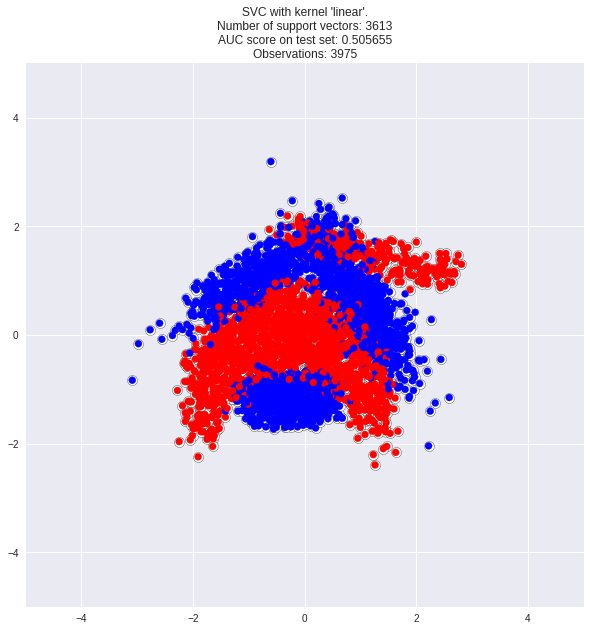

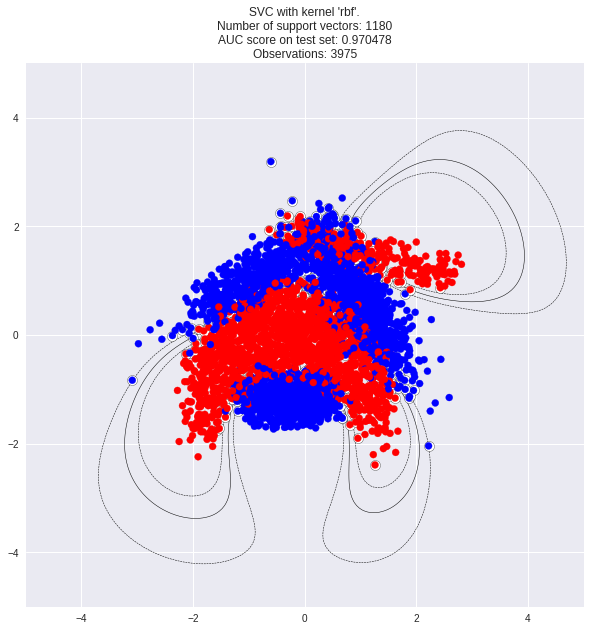

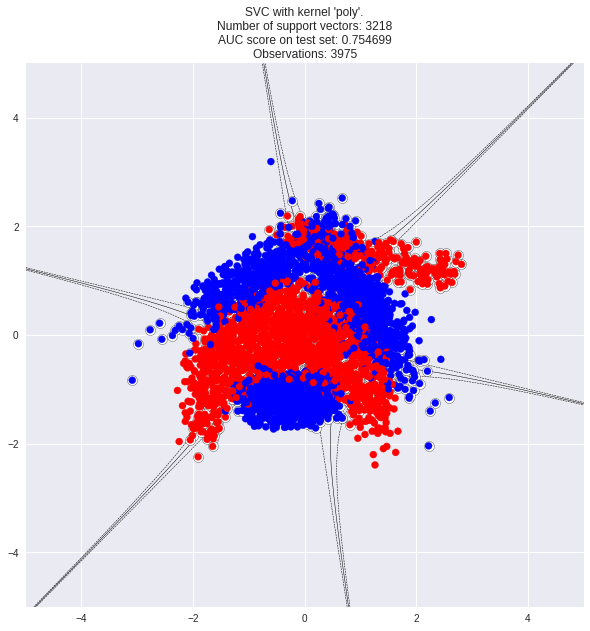

In [41]:
################################################################################
################## Solution 1a ##################
################################################################################

# 1a) Use a linear, polynomial and radial basis function (RBF) kernel, using 
#     their default hyperparameters. Evaluate the performance of each kernel 
#     using the test set and AUC. Which one works best?

# Use a linear, polynomial and radial basis function (RBF) kernel, using their 
# default hyperparameters.
classifiers = { "linear": SVC(kernel = "linear"), 
               # Default is rbf, but better to be explicit :)
               "rbf" : SVC(kernel = "rbf"), 
               "poly" : SVC(kernel="poly")
              }


# Evaluate the performance of each kernel using the test set and AUC. Also plot
# results
results = []
for name, model in classifiers.items():
  auc_score_test, auc_score_train = runSVC(model, X_train, y_train, 
                                           X_test, y_test, name, plot = True)
  results.append([name, auc_score_test, auc_score_train])

# Show AUC scores
pd.DataFrame(results, columns = ["Kernel", "AUC score test", "AUC score train"])


**Team discussion**

The results show that `RBF` kernel works the best. The AUC score of the test set is 0.97 and the contour lines seem to fit the train classes very well. The second most outperformant kernel is `poly`, with a good AUC score but with the contours not really fitting the classes. Finally, for the `linear` kernel we observe a poor performance, with low AUC scores in both train and test set and not identifiable contours, indeed the number of support vectors it uses is almost the totallity of the observations in the traing seet (3613/3975).

The bad performance of the `linear` kernel may be due to the small number of features (`2`) while `RBF` and `poly` can handle that scenario better.

### 2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

C gamma  AUC test score  AUC train score
0     0.01  0.01            0.56             0.58
1     0.01  auto            0.89             0.89
2     0.01  1000            0.91             1.00
3     1.00  0.01            0.56             0.57
4     1.00  auto            0.97             0.97
5     1.00  1000            0.90             1.00
6  1000.00  0.01            0.86             0.85
7  1000.00  auto            0.97             0.97
8  1000.00  1000            0.87             1.00

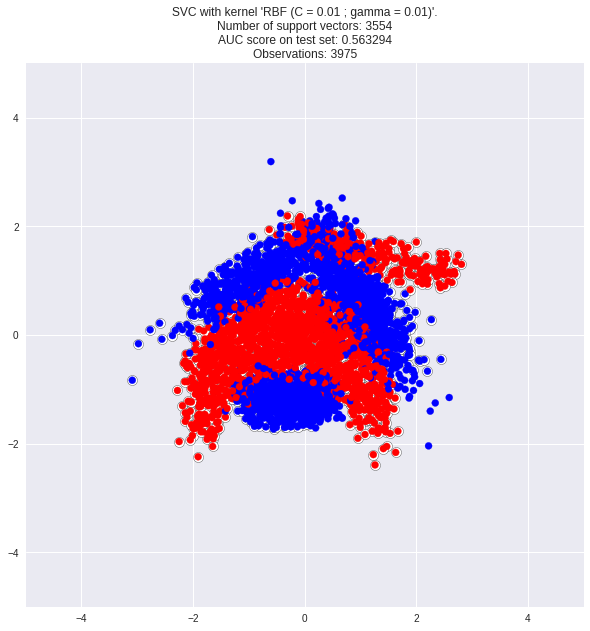

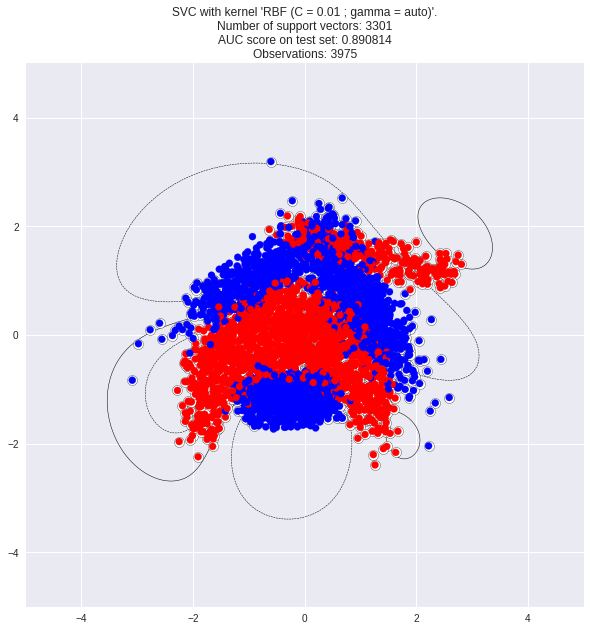

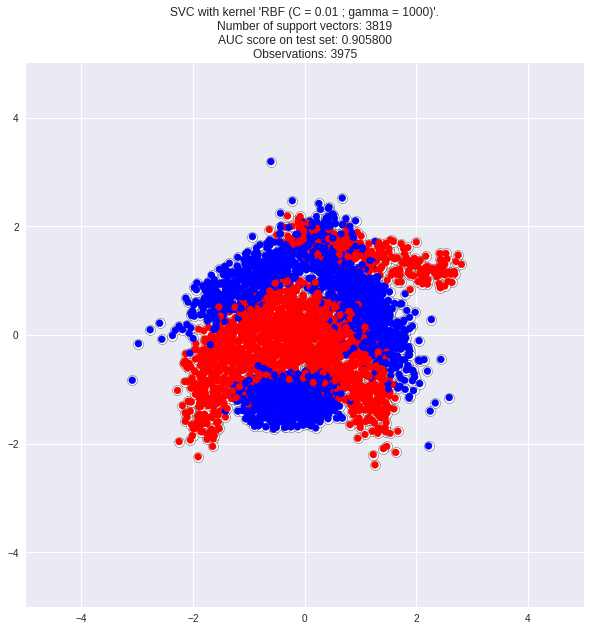

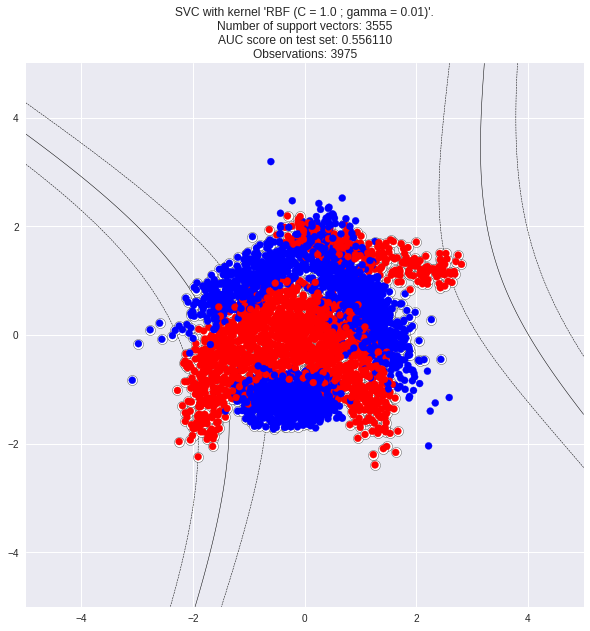

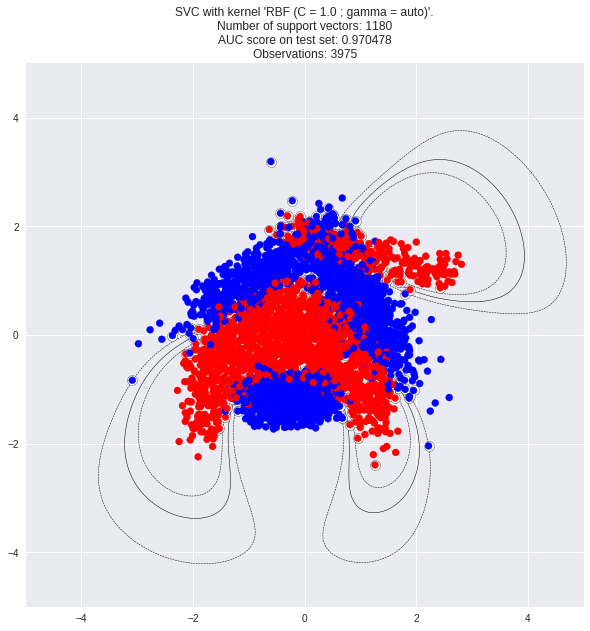

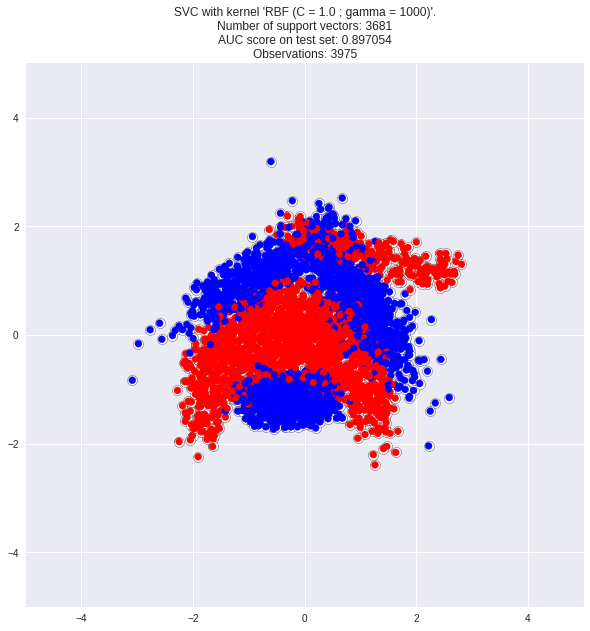

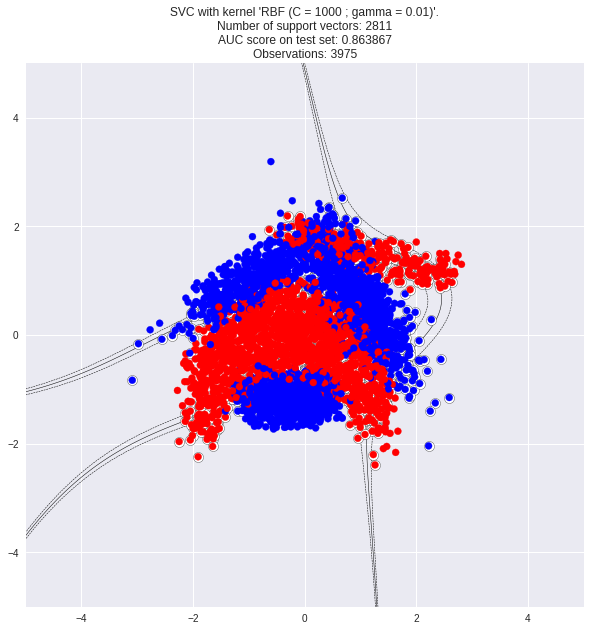

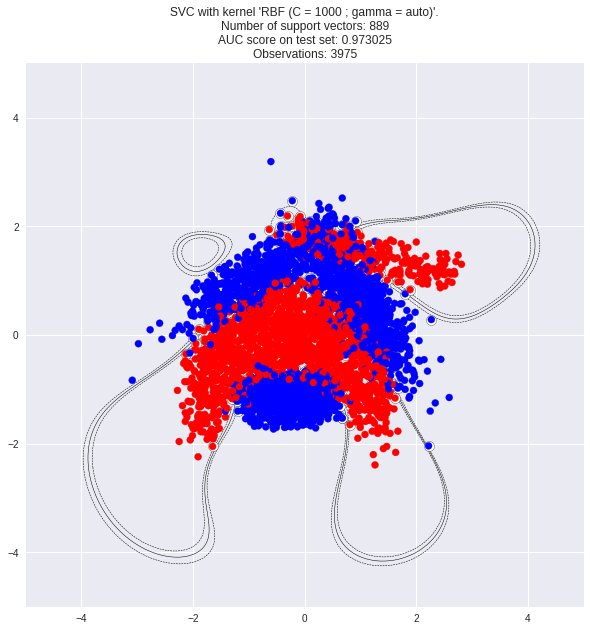

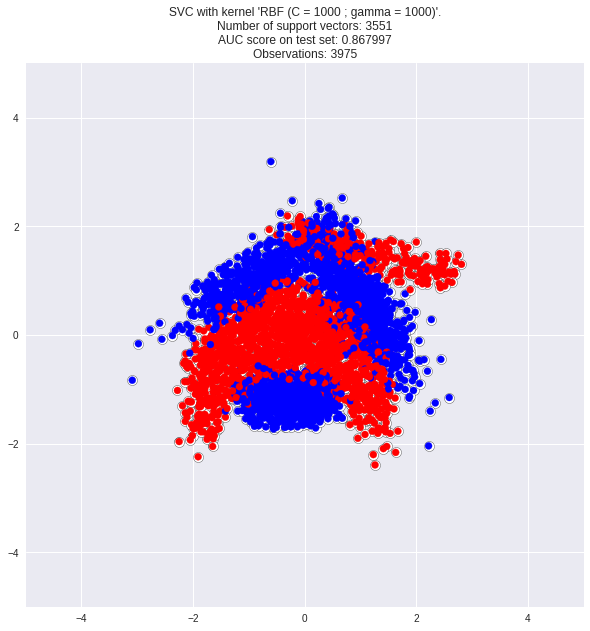

In [42]:
# 2a. Manual tunning

# 0. Variables
params = { 'C' : [0.01, 1.0, 1000], # Default is 1.0
           'gamma' : [0.01, 'auto', 1000]
         }

results = []
# 2. Run for each of the 9 combinations
for c in params['C']:
  for gamma in params['gamma']:  
    rfbSVC = SVC(C = c, gamma = gamma)
    auc_test_score, auc_train_score = runSVC(rfbSVC, X_train, y_train, 
                                              X_test, y_test, 
                       label = "RBF (C = {} ; gamma = {})".format(c, gamma),
                       plot = True)
    
    results.append([c, gamma, auc_test_score, auc_train_score])

pd.DataFrame(results, columns = ["C", "gamma", "AUC test score", "AUC train score"])


**Team discussion**

We find that when both parameters have a low value, the model is underfitting and performance in the train set is poor, however a high value of `C` can "compensate" a low value in `gamma`. Contrarely, we find that regardless the value of `C`, a high `gamma` makes the model to overfit (train score of `1`) and it does not work very accurately for the train set. 

For our dataset, we find the best results in the default values as well as in `C = 1000` and `gamma = auto`.


Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  4.9min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  8.9min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed: 13.7min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed: 19.2min
[Parallel(n_jobs=16)]: Done 2250 out of 2250 | elapsed: 33.4min finished


SVC-RBF best score: 0.9691007914454527
SVC-RBF best parameters: {'C': 2048, 'gamma': 8}


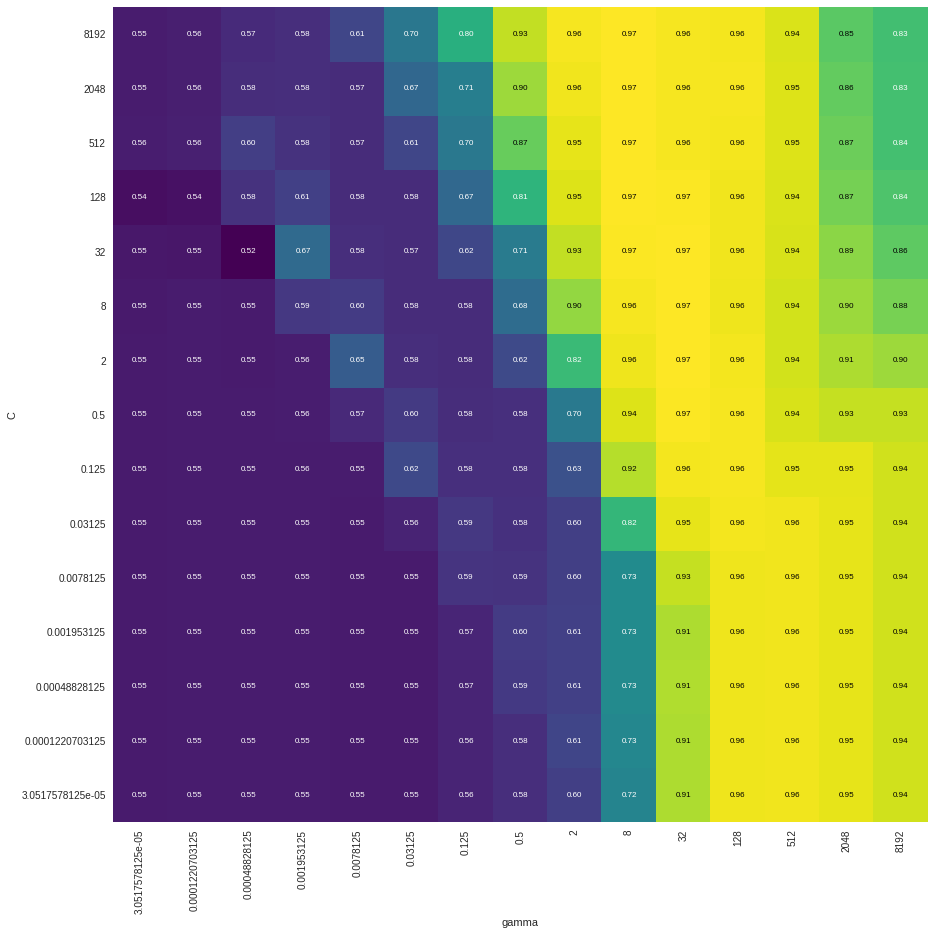

In [142]:
# 2b. GridSearch
gridValues = [2 ** x for x in range(-15, 15, 2)]
# gridValues = [2 ** x for x in range(-15, 15, 2)]
params = { 'C' : gridValues, # Default is 1.0
           'gamma' : gridValues
         }

# # 1. Scale data (better results)
# X_train_scaled, X_test_scaled = scaleData(X_train, X_test)

best_score, best_params = runGridSearch(SVC(), X_train, y_train, params)

print("SVC-RBF best score: {}\nSVC-RBF best parameters: {}".format(
    best_score, best_params))

For this exercise, we find that that our best score is `0.9691` and the best parameters are `C = 2048` & `gamma = 8`. We confirm that low values of both parameters provide poor results (underfitting) and high values of both do not work well in test sets (overfitting).


## Building Kernels (4 points (0.5+0.5+1+2))

Consider the artificial dataset given below. It represents a sine wave with added noise.

1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40]. 

    - Does it fit the data well? Does it extrapolate well (in the range [30,40])? Explain your findings. 
    - Can you get better results by tweaking the kernel or the other SVM parameters?
    
2. Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

      $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
    - Build an SVM regressor using that kernel by passing your kernel function as the `kernel` hyperparameter. 
    - Fit it on the sine data and plot the predictions on all data points. Interpret the results.
    
3. Since this data is periodic, it makes sense to implement a periodic kernel instead. 

    - This is the Exponential Sine Squared kernel, with length scale $\Gamma$ and periodicity $P$:
  $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$
    - Implement it, using the defaults $\Gamma=1$, periodicity $P=1$, and Euclidean distance.
    - Train an SVM regressor with it, fit in on the same data and plot the result. Interpret the outcome. 
    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

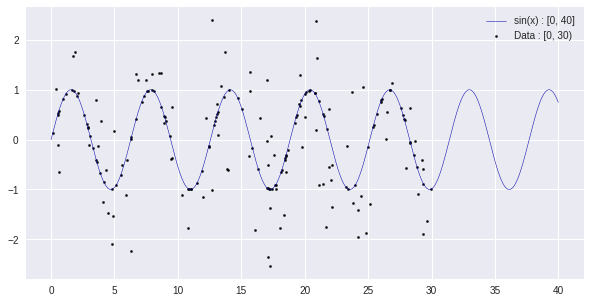

In [18]:
# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility 
X = 30 * rng.rand(200, 1) # Shape (200,1). 30 * [0, 1) = [0, 30)
y = np.sin(X).ravel() # Compute the sin for [0, 30)
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise to y

# [0, 40]. Shape (10000, 1)
X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on 
true_y = np.sin(X_plot) # and the 'true' target function (true sin)

pl = plt.figure(figsize=(10, 5))
pl = plt.scatter(X, y, c='k', s = 5, label="Data : [0, 30)")
pl = plt.plot(X_plot, true_y, label = "sin(x) : [0, 40]");
pl =  plt.legend()

### 1 . Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40].

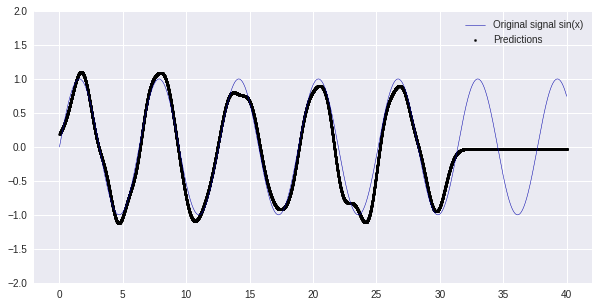

In [19]:
# 1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions
#    on all data points in [0, 40].

################################################################################
################# Run SVR and return predictions for X_test set ################
################################################################################
def runPredictDefaultSVR(X, y, X_test):
  svmr = SVR()
  svmr.fit(X, y)
#   print(svmr.support_vectors_.shape)
  predictions = svmr.predict(X_test)
  return predictions

################################################################################
############### Plot true labes and the predictions for an X set ###############
################################################################################
def makePlot(X, predictions, true_y, signalLabel = "sin(x)" ):
  plt.figure(figsize=(10, 5))
  plt.scatter(X, predictions, c = 'k', s = 5, label = 'Predictions')
  plt.plot(X, true_y, label = "Original signal {}".format(signalLabel));
  plt.legend( loc = 'best')
  plt.ylim(min(true_y) - 1, max(true_y) + 1)

################################################################################
##################################### MAIN #####################################
################################################################################

# Fit an SVM Regressor with the default RBF kernel
predictions = runPredictDefaultSVR(X, y, X_plot)

# Plot the predictions on all data points in [0, 40]. X_plot is defined from
# [0, 40]
makePlot(X_plot, predictions, true_y)



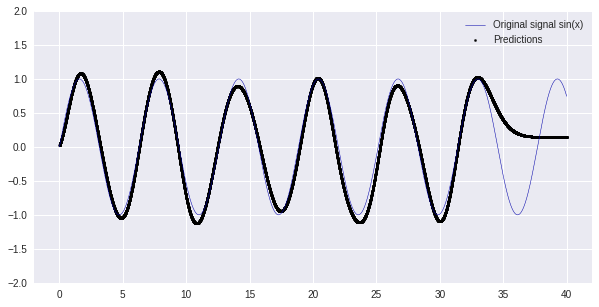

In [14]:
################################################################################
######################### Trying to improve the default ########################
################################################################################
def runPredictImproveSVR(X, y, X_test):
  svmr = SVR( gamma = 0.15, C = 200)
  svmr.fit(X, y)
#   print(svmr.support_vectors_.shape)
  predictions = svmr.predict(X_test)
  return predictions

# Fit an SVM Regressor with the default RBF kernel
predictions = runPredictImproveSVR(X, y, X_plot)

# Plot the predictions on all data points in [0, 40]. X_plot is defined from
# [0, 40]
makePlot(X_plot, predictions, true_y)


**Team discussion**

The default SVR (RBF kernel) gives a pretty good prediction of the true `sin(x)`, trained on the noisy signal. We can observe that in the periods where we have more noise, the predictions is not accurate. It comes interesting that for an small range of values after `x = 30` the model is able to predict the `sin` signal, but close to `sin(x > 30) = 0`, its accuracy drops.

On the other hand we intuitively thought about how to get better results. Since we observe that periods with noise are still preserving strange shapes, we know that the model is probably overfitting, hence we can play with `gamma` and we can find that with `gamma = 0.1` we can underfit the noise. Additionally, by having a `C` with a high value we can decrese the overfitting and then the predictions for `sin( x > 30)` get better but still the kernel is not able to extend to the remaining missing range.

### 2 . Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

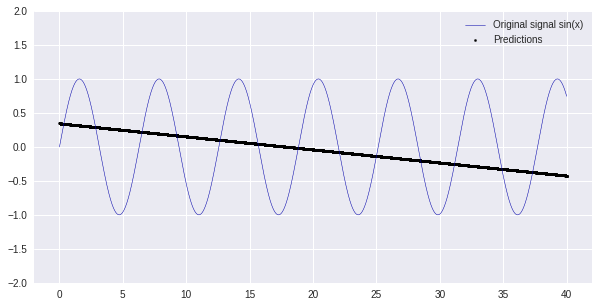

In [20]:
################################################################################
################### Our implemenatation of the Linear Kernel ###################
################################################################################
def customLinearKernel(A, B):
  return np.dot(A, B.T)

################################################################################
################## Build an SVM Regressor with custom kernel ###################
###################### fit it and predict the a test set #######################
################################################################################
def runPredictCustomSVR(X, y, X_test, kernel):
  svmr = SVR(kernel = kernel)
  svmr.fit(X, y)
#   print(svmr.support_vectors_.shape)
  predictions = svmr.predict(X_test)
  return predictions

################################################################################
############### Helper function to test the correctness of our  ################
############################### implementation  ################################
################################################################################
def isCustomLinearKernelValid(my_predictions, X, y, X_test):
  runPredictCustomSVR(X, y, X_plot, "linear") 
  return np.sum(predictions == my_predictions) == len(X_test)

################################################################################
##################################### MAIN #####################################
################################################################################

# Run and predict with custom kernel
predictions = runPredictCustomSVR(X, y, X_plot, customLinearKernel)
# Make the plot of true_y vs. predictions
makePlot(X_plot, predictions, true_y)

**Team discussion**

An SVR is not able to predict the `sin(x)` function from the noisy data. Its prediction is simply a line that crosses the middle value of the test range, with negative slope. Indeed, while exploring the support vectors one can find that the model found 0 of them, which is expected since a `sin` function is not linearly separable.

### 3 . Implement a periodic kernel instead

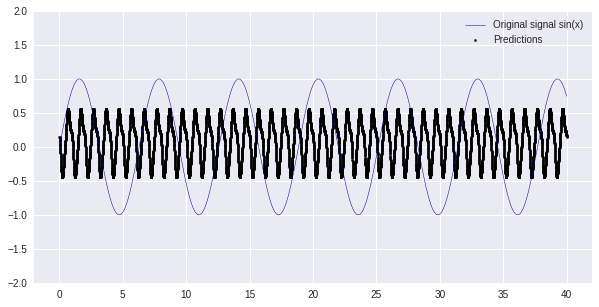

In [21]:
# 3. 

################################################################################
########## Our implemenatation of the Exponential Sine Squared Kernel ##########
################################################################################
def buildExpSinSquared(L, P):
  def expSinSquared(A, B, L = L, P = P):
    dists = cdist(A, B) # Euclidean distance
    K = np.exp( -L * (np.sin( (np.pi / P) * dists)) ** 2)
    return K
  return expSinSquared

# We build an SVR with gamma = 1 and P = 1, as well as Euclidian distance...
predictions = runPredictCustomSVR(X, y, X_plot, buildExpSinSquared(1, 1))
# predictions = runPredictCustomSVR(X, y, X_plot, ExpSineSquared(1,1))

# ... and we plot the results of the predictions
makePlot(X_plot, predictions, true_y)

**Team discussion**

The SVM regressor now predicted a signal function, but it is not of the same shape of the desired `sin(x)`. First, the functions is in a range close to `(-0.44, 0.56)` (amplitude 1) and a narrow bandwidth, furthermore, the signal looks slightly shifted.




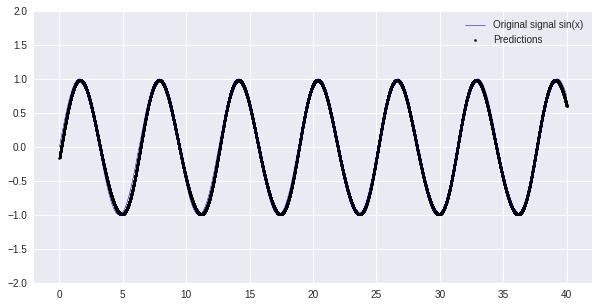

In [22]:
# Trying to improve by manually adjusting

predictions = runPredictCustomSVR(X, y, X_plot, buildExpSinSquared(0.5, 6.25))
# predictions = runPredictCustomSVR(X, y, X_plot, ExpSineSquared(1,1))

# ... and we plot the results of the predictions
makePlot(X_plot, predictions, true_y)

**Team discussion**

Gamma represents the amplitude and P represents the period (can adjust bandwidth). We have manually tunned this parameters and found that a `Gamma = 0.5` and `P ~ 6.25` can accurately predict the original `sin(x)` even when trained on the noisy signal.


Optimal values for kernel:
	L : 0.1 ; P : 6

Best score : 0.6724306370800693


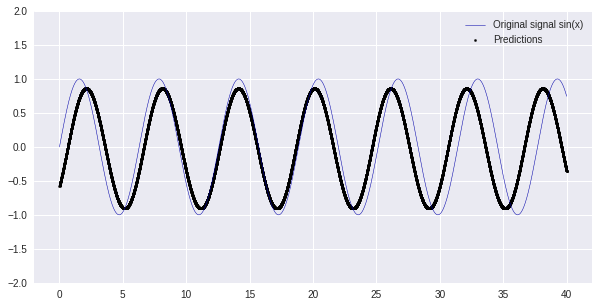

In [23]:
# 3e) Optimize Γ and periodicity P

def kernelSVRGridSearch(X_train, y_train, X_validation, y_validation, kernelParams):
  all_scores = []
  best_P = 0
  best_L = 0
  best_score = 0
  current_score = 0
  for L in kernelParams['L']:
    for P in kernelParams['P']:
      model = SVR(kernel = buildExpSinSquared(L, P))
      model.fit(X_train, y_train)
      
      # true_y is the ground truth
      current_score = model.score(X_validation, y_validation)
      all_scores.append([L, P, str(current_score)])
      if current_score > best_score :
        best_score = current_score
        best_P = P
        best_L = L
      
  return best_score, best_P, best_L, all_scores

# Define parameters for kernel
paramsKernel = {'L': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 'P' : [1,  6, 10,  20,  25,  50,  75, 100] }

# Run the Grid Search
best_score, best_P, best_L, all_scores = kernelSVRGridSearch(X, y, X_plot, true_y, paramsKernel)
print("\nOptimal values for kernel:\n\tL : {} ; P : {}".format(best_L, best_P))
print("\nBest score : {}".format(best_score))

# All scores
pd.DataFrame(all_scores, columns = ["Gamma", "P", "Score on true_y"])

# Run the prediction function
# predictions = runPredictCustomSVR(X, y, X_plot, ExpSineSquared(best_P, best_L))
predictions = runPredictCustomSVR(X, y, X_plot, buildExpSinSquared(best_L, best_P))
makePlot(X_plot, predictions, true_y)


**Team discussion**

Intentionally, we included a value close to the one we had found in our manual adjustment. It can be seen that this is indeed the value that maximizes the true prediction for the true `sin(x)` function, for our candidate values. One can see that `P` is the most important parameter for this problem.

### 4 . We now make the problem a bit more challenging by adding an upward trend:

- Fit the same SVM using the optimal parameters from the previous subtask and plot the results. Do they still work? Explain what you see.
- Fit a Gaussian process (GP) using the kernels given below. First use the singular ExpSineSquared kernel (the implementation provided by sklearn this time), then build a new kernel consisting of the 3 components given below. Use both to predict all points for the "rising noisy sine" data and plot the results as usual. Interpret the results.
    - For the GP, it may help to use `normalize_y=True` since the y-values are not around 0. Setting `alpha=0.1` may help with possible numerical issues, otherwise keep it at 0.
- Also plot the _uncertainty interval_ around the predictions. You can ask the GP to return the standard deviation during prediction with the `return_std=True` hyperparameter. Plot a band 2 standard deviations above and below the prediction. You can use MatPlotLib's `fill_between` as shown in class.
    - You can combine the 3 models in one plot for easy comparison.
- We've provided reasonable values for the kernel hyperparameters above. Can you optimize them further to get an even better fit? Think about what the hyperparameters do and optimize the ones you think are most worth tuning.

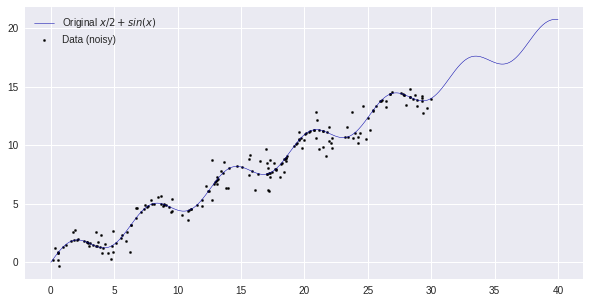

In [24]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

pl = plt.figure(figsize=(10, 5))
pl = plt.scatter(X, y, c='k', s = 5, label='Data (noisy)')
pl = plt.plot(X_plot, true_y, label = "Original $x/2 + sin(x)$")
pl = plt.legend()



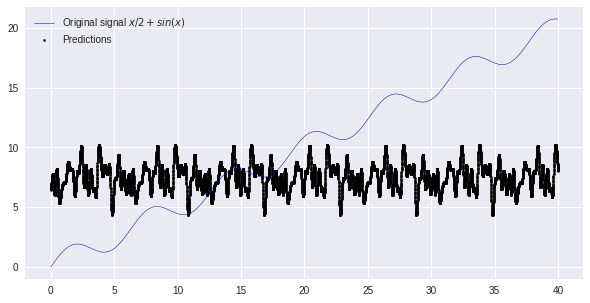

In [25]:
# 4a. Fit the same SVM using the optimal parameters from the previous subtask 
#     and plot the results. Do they still work? Explain what you see.
kernel_simple = ExpSineSquared( length_scale = best_L, periodicity = best_P) # periodic component

predictions = runPredictCustomSVR(X, y, X_plot, kernel_simple)
makePlot(X_plot, predictions, true_y, signalLabel = "$x/2 + sin(x)$")


**Team discussion**

We still observe that the prediction may suggest a period, but the shape is not fitting the objective function. We should find a way to "rotate" the signal to rise and adjust again `Gamma` and `P`.

In [0]:
# We use this for GP only

from sklearn.gaussian_process.kernels import Kernel, StationaryKernelMixin, NormalizedKernelMixin, Hyperparameter
from scipy.spatial.distance import pdist, cdist, squareform

class MyCustomKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
  
    def __init__(self, length_scale = 1.0, periodicity = 1.0,
                 length_scale_bounds = (1e-5, 1e5),
                 periodicity_bounds = (1e-5, 1e5)):
        self.length_scale = length_scale
        self.periodicity = periodicity
        self.length_scale_bounds = length_scale_bounds
        self.periodicity_bounds = periodicity_bounds

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter(
            "length_scale", "numeric", self.length_scale_bounds)

    @property
    def hyperparameter_periodicity(self):
        return Hyperparameter(
            "periodicity", "numeric", self.periodicity_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is None:
            dists = squareform(pdist(X, metric='euclidean'))
            arg = np.pi * dists / self.periodicity
            sin_of_arg = np.sin(arg)
            K = np.exp(- self.length_scale * (sin_of_arg) ** 2)
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            dists = cdist(X, Y, metric='euclidean')
            K = np.exp(- self.length_scale * (np.sin(np.pi / self.periodicity * dists)) ** 2)

        if eval_gradient:
            cos_of_arg = np.cos(arg)
            # gradient with respect to length_scale
            if not self.hyperparameter_length_scale.fixed:
                length_scale_gradient = \
                    4 / self.length_scale**2 * sin_of_arg**2 * K
                length_scale_gradient = length_scale_gradient[:, :, np.newaxis]
            else:  # length_scale is kept fixed
                length_scale_gradient = np.empty((K.shape[0], K.shape[1], 0))
            # gradient with respect to p
            if not self.hyperparameter_periodicity.fixed:
                periodicity_gradient = \
                    4 * arg / self.length_scale**2 * cos_of_arg \
                    * sin_of_arg * K
                periodicity_gradient = periodicity_gradient[:, :, np.newaxis]
            else:  # p is kept fixed
                periodicity_gradient = np.empty((K.shape[0], K.shape[1], 0))

            return K, np.dstack((length_scale_gradient, periodicity_gradient))
        else:
            return K

    def __repr__(self):
        return "{0}(length_scale={1:.3g}, periodicity={2:.3g})".format(
            self.__class__.__name__, self.length_scale, self.periodicity)


In [0]:
def doGaussianProcess(kernel, X, y, X_validation, y_validation, title):
  # Instanciate a Gaussian Process model
  gp = GaussianProcessRegressor(kernel = kernel, 
                                alpha = 0.1, #If alpha 0, we get an exception
                                normalize_y = True)

  # Fit to data using Maximum Likelihood Estimation of the parameters
  gp.fit(X, y)

  # Make the prediction
  y_pred, sigma = gp.predict(X_validation, return_std = True)
  
  # Plot the results with a 2-sigma confidence interval
  fig = plt.figure(figsize = (10,10) )
  plt.plot(X_validation, y_validation, 'r:', label=u'$f(x) = x/2 + \sin(x)$')
  plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
  plt.plot(X_validation, y_pred, 'b-', label=u'Prediction')
  plt.fill(np.concatenate([X_validation, X_validation[::-1]]),
           np.concatenate([y_pred - 2 * sigma,
                          (y_pred + 2 * sigma)[::-1]]),
           alpha=.5, fc='b', ec='None', label='2-sigma interval')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.ylim(-10, 20)
  plt.legend(loc='upper left')
  plt.title(title)
  return y_pred, sigma


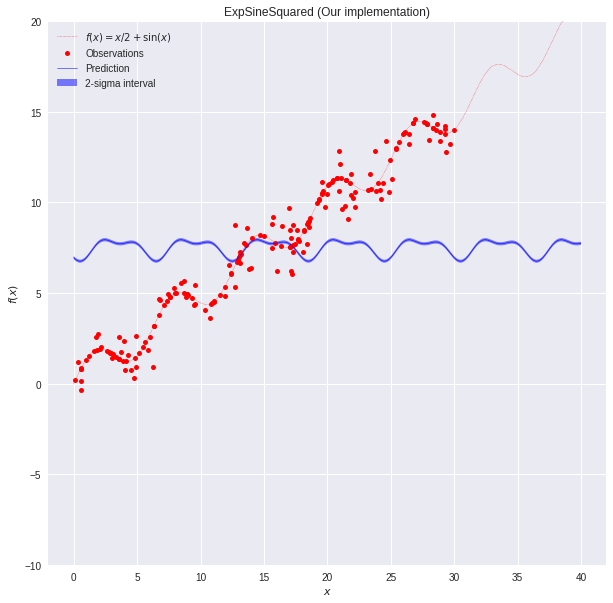

In [28]:
# Gaussian process with our simple kernel
predictions, sigma = doGaussianProcess(MyCustomKernel(best_L, best_P), X, y, X_plot, true_y,  
                                       title = "ExpSineSquared (Our implementation)")

In [0]:
# Replace `length_scale` and `periodicity` with the values found in the previous part.
kernel_simple = ExpSineSquared( length_scale = best_L, periodicity = best_P) # periodic component

k1 = 4300 * RBF(length_scale = 70.0)  # long term smooth rising trend
k2 = 6 * RBF(length_scale = 90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * RBF(length_scale = 0.134) + WhiteKernel(noise_level=0.035)  # noise terms


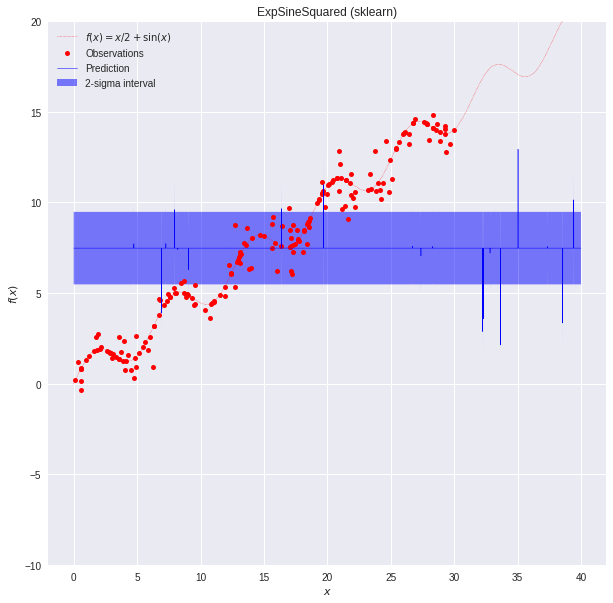

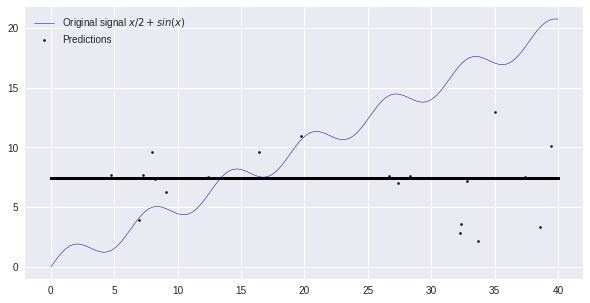

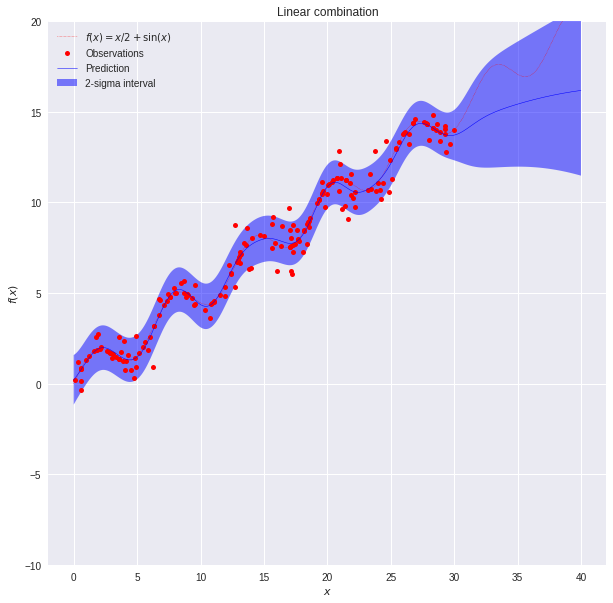

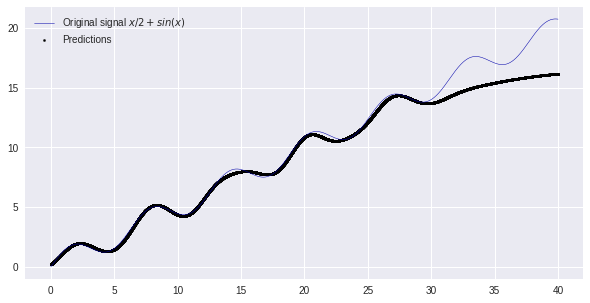

In [32]:

# Gaussian process with our simple kernel
predictions, sigma = doGaussianProcess(kernel_simple, X, y, X_plot, true_y,  
                                       title = "ExpSineSquared (sklearn)")
# Plot the predictions
makePlot(X_plot, predictions, true_y, signalLabel = "$x/2 + sin(x)$")

# Gaussian process for our "composed" kernel... Not sure if sum of kernels is correct...
predictions, sigma = doGaussianProcess(k1 + k2 + k3, X, y, X_plot, true_y,
                                      title = "Linear combination")
# Plot the predictions
makePlot(X_plot, predictions, true_y, signalLabel = "$x/2 + sin(x)$")


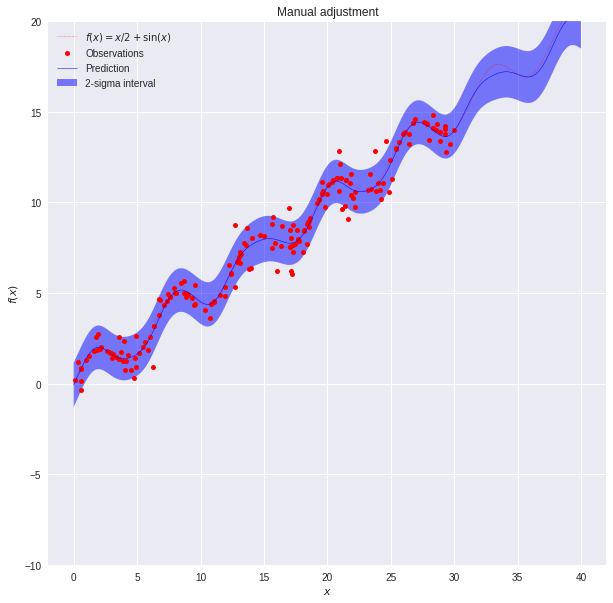

In [127]:
# Manual adjustment 

k1 = 4300 * RBF(length_scale = 90.0)  # long term smooth rising trend
k2 = 6 * RBF(length_scale = 90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * RBF(length_scale = 0.134) + WhiteKernel(noise_level = 0.035)  # noise terms

predictions, sigma = doGaussianProcess(k1 + k2 + k3, X, y, X_plot, true_y, "Manual adjustment")

**Team discussion**

From these experiments, we find that our kernel implementation can more or less learn the periodicity of the signal, but it cannot do anything for the raising pattern. On the other hand, the `sklearn` implementation of the Exponential Sine gives a bad result (an horizontal line) - this disagreement is expected since we use the alternative formulation of the kernel. 

With respect to the kernels provided (`k1`, `k2` and `k3`) we can come up with a good approximation with the default values by making a sum of the three. This is, the rising pattern and the shape are learned for the points in the train range, but for the missing range it still does not extend well. We solved this by manually tunning the `lenght` parameter of `k1` to cover a broader range.


## Bayesian updates (3 points (2+1))

We consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1000 points) and try to learn the (very noisy) trend. 

1. Train a Gaussian process on an increasing amount of samples of the training data. Use a simple RBF kernel:
`RBF(10, (1e-2, 1e2))`

 - Start with 10 _random_ samples and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Also compute $R^2$ on the training data.
 - Repeat and 10 more points, retrain and redraw. Do this a couple of times and interpret/explain what you see. 
 
2. Train the Gaussian on the full training set.

 - Plot the predictions (including the uncertainty interval) on the full dataset. Evaluate on the test set using $R^2$ 
 - Interpret the results. Is the kernel right? Is the GP under/overfitting?
 - Try to improve the results by tuning the kernel. Do this either manually or using a small grid/random search.

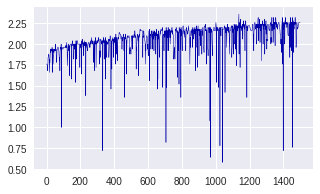

In [14]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);
data=X
train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1500)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T

pd.Series(X[:1500,0]).plot()

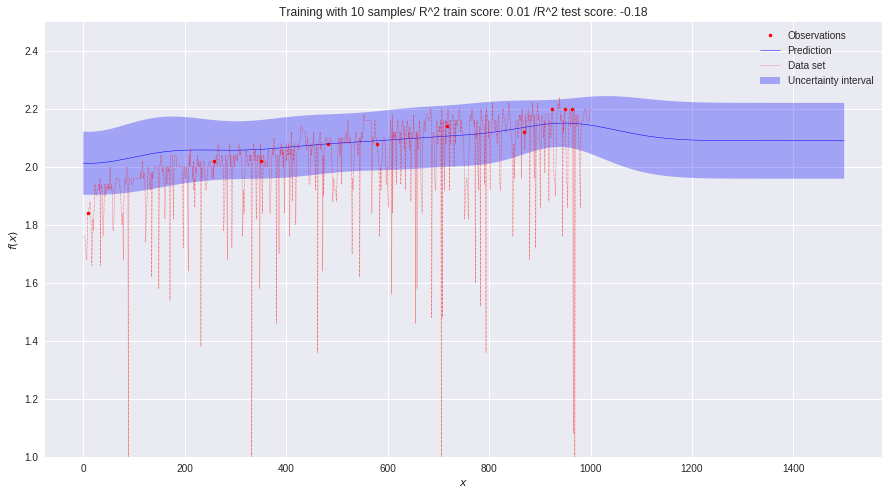

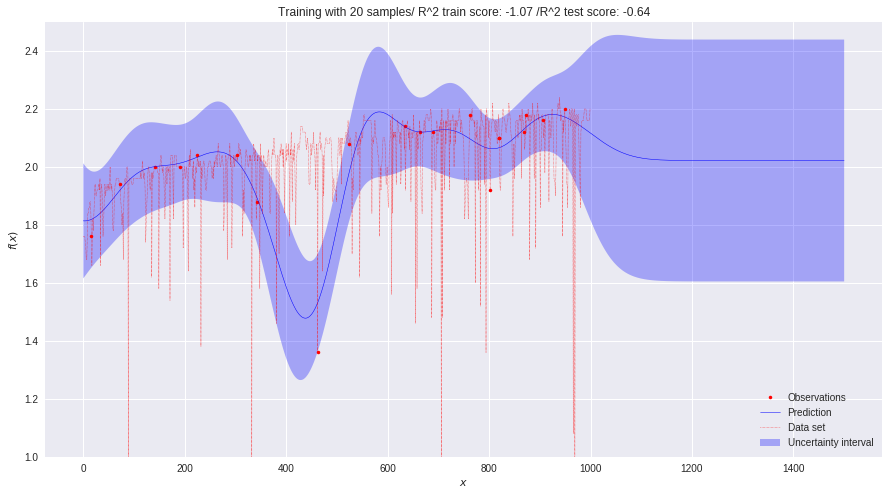

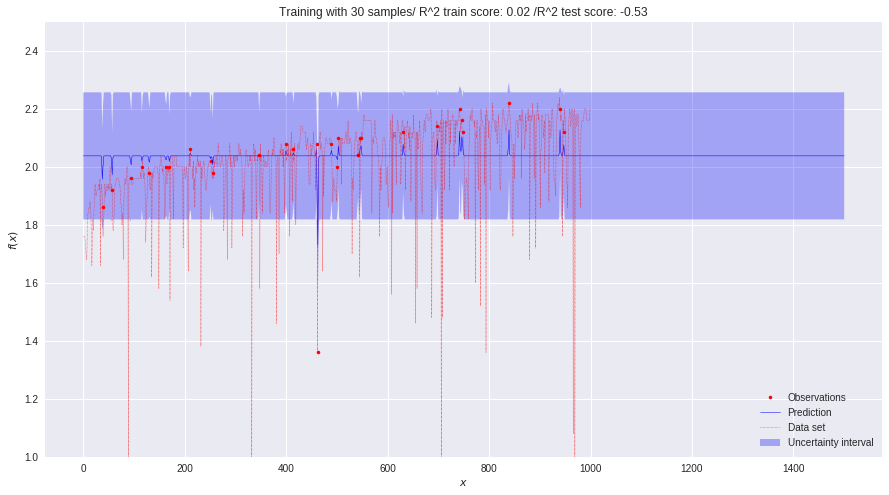

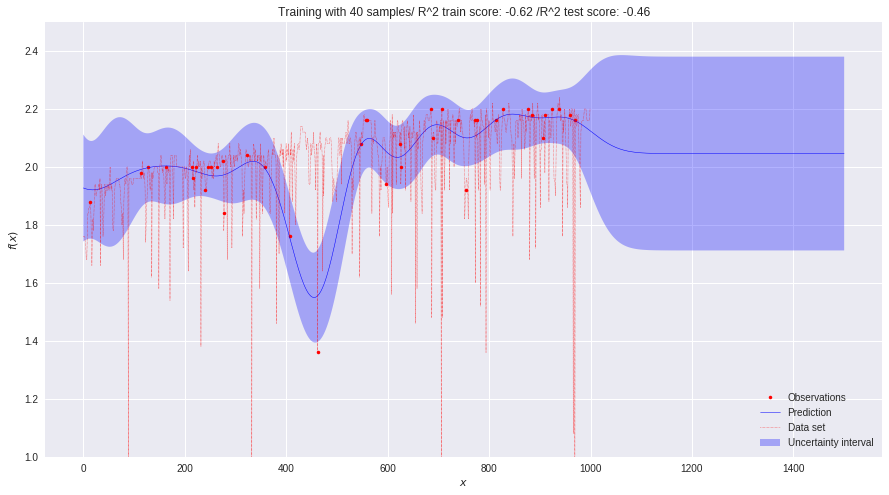

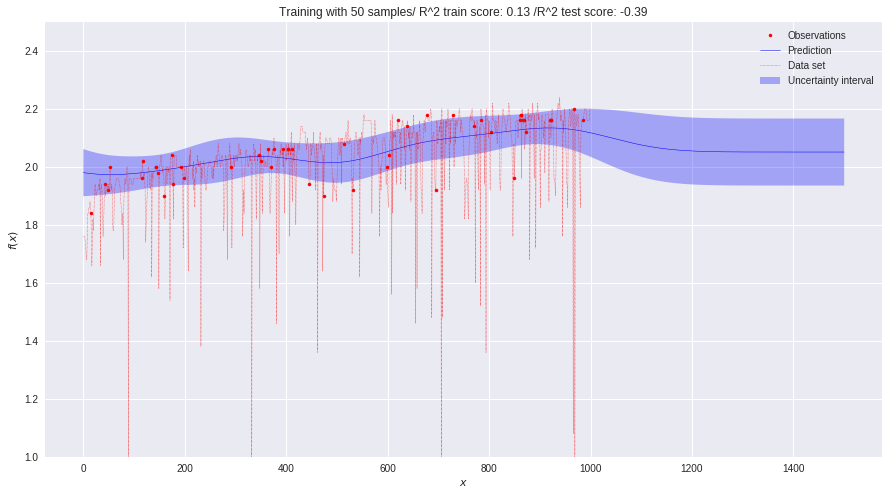

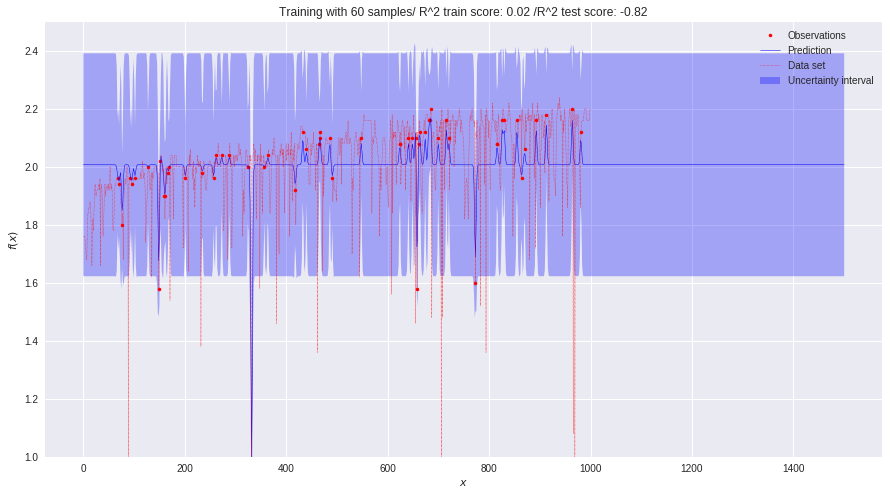

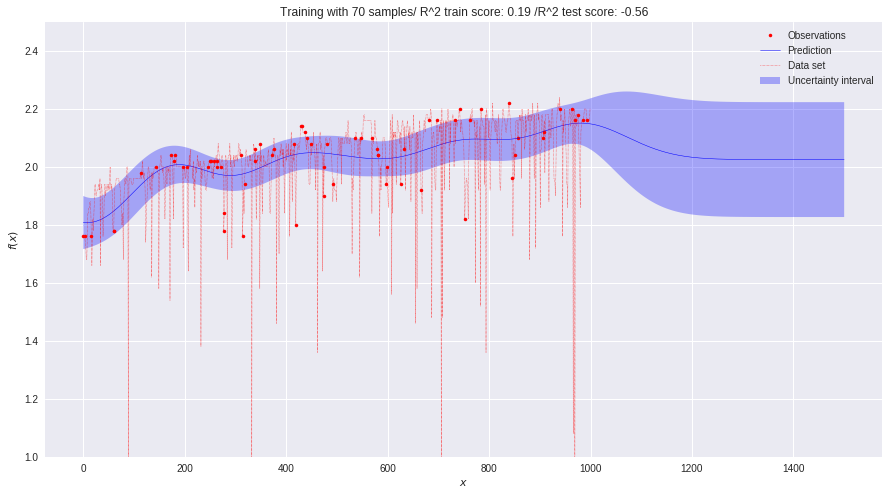

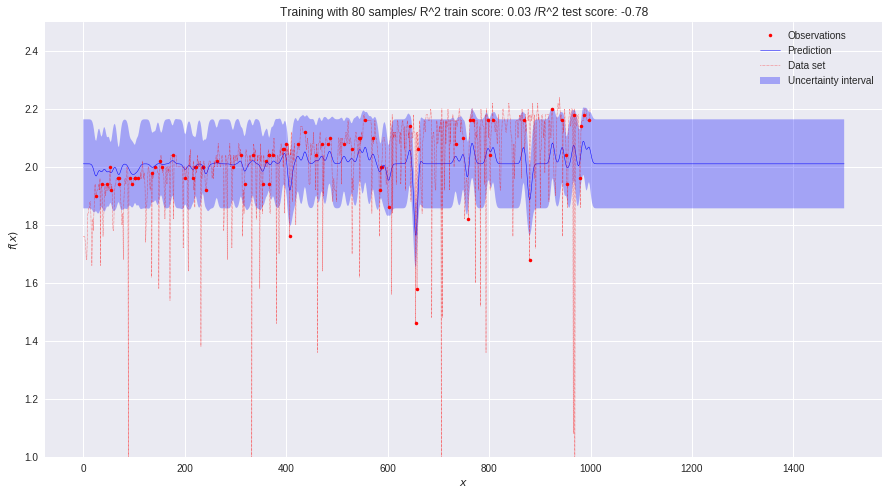

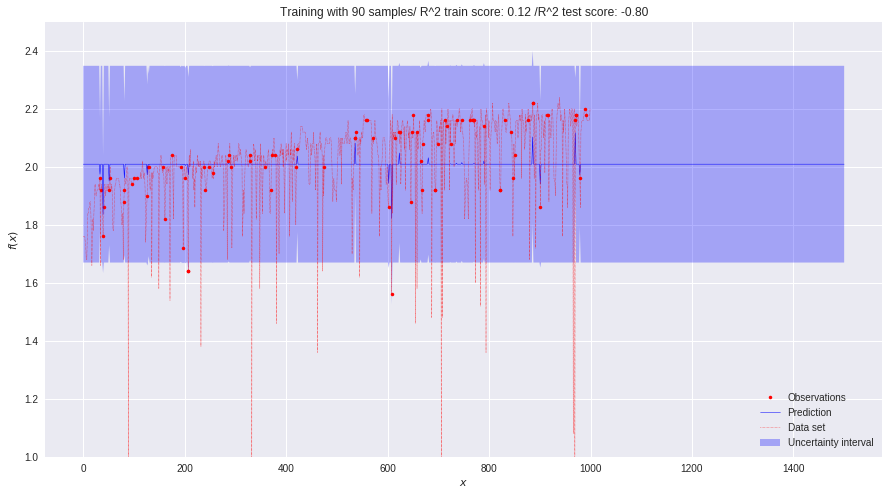

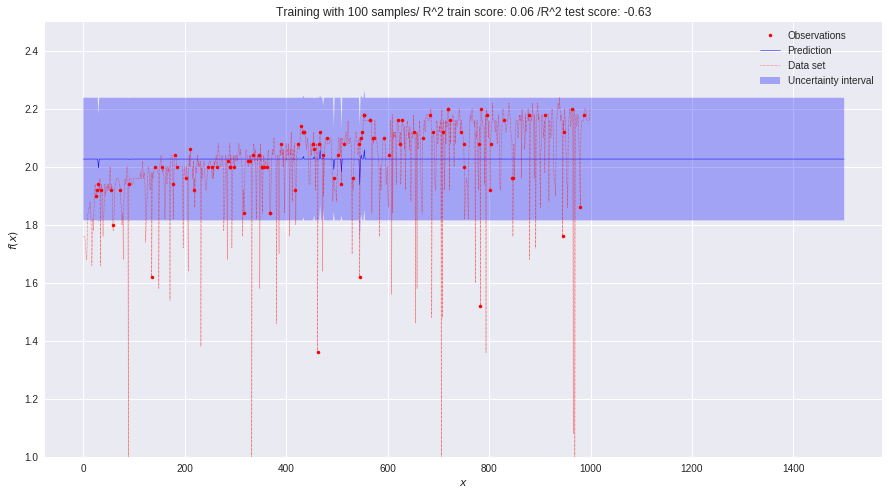

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import random
import seaborn as sns
import matplotlib.pyplot as plt


numHigh = len(X_train)                              #we need length of train to create the samples
n = 10   # number of random samples
samples=[]

for k in range(10):
    samples=[]
    for x in range (0, n):
        samples.append(random.randint(0, numHigh))
        
    samples.sort()                                   #sort the samples for y
    y = y_train[samples]                             #take the targets for your samples
    samples = np.squeeze(np.asarray(samples))        #make samples into array
    samples = np.reshape(samples, (-1, 1))
    y = np.reshape(y, (-1, 1))
    X=samples
    y = y.ravel()
    # Mesh the input space for evaluations of the real function, the prediction and its MSE
    x = np.atleast_2d(np.linspace(0, 1500, 1000)).T   
    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.01, n_restarts_optimizer=9,normalize_y=True)   #we also have alpha for regurilization for smoother incertain intervals
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)
    n += 10                 #add 10 samples each time
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)
#   X_all = X_all.reshape((1500,1))       <- to delete
#   X_right = X[:1500].reshape((1500,1))  <- to delete
    #score for training
    score = gp.score(X_train, y_train[0:1000])    #y_train 
    #score for testing
    score_test = gp.score(X_test, y_test)
    fig = plt.figure(figsize=(15,8))
    plt.plot(X, y, 'r.', markersize=7, label=u'Observations')
    plt.plot(x, y_pred, 'b-', label=u'Prediction')
    plt.plot(np.array(list(range(1000))), data[:1000], 'r:', label='Data set')   #raw data
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.3, fc='b', ec='None', label='Uncertainty interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(1, 2.5)
    plt.title("Training with " + str(n-10) + " samples/ R^2 train score: {:.2f}" .format(score) + " /R^2 test score: {:.2f}".format(score_test) )
    plt.legend(loc='best');
    
     

              

    

**Team discussion**

As we can see the more samples we add in our training the better results we get, though there is a danger of overfiting. We also tune our normalization parameter 
as  due to the fact that in the "prediction" space after 1000 points, the predictor would be 0. This happens because  our prior works with a zero mean as default(prior assumes 0 mean, and a covariance matrix).
The normalization parameter here basically will add the predicted mean at the end since there are no data for training. This also counters the prediction drop between the
samples, which would be drawn to 0 otherwise. We also add a regurilization parameter since our data is noisy. That will smooth our uncertain intervals (plotted with blue)
and will make the prediction not that "flimsy".

It is obvious that for many samples (i.e. 100) the GP is overfitting quite a lot. If we try to increase the alpha to counter this though the the prediction
will follow a straigh line so after running a number of examples with different parameters of alpha we concluded that a very small alpha give relatively good results.
We also observe that for a smaller number of samples the predictor predicts the mean with a significantly larger uncertainty interval, since there is no data
to inform it. This does not happen for larger number of samples since we find "overall" of the data, thus the predictor seems to be lower after 1000.

The R squared scores perform as we expected. The test score are always lower since all the test values are outside of the training range. 
This happens because we extrapolate on noisy data so it should be very hard to get even positive scores. For the training data the scores seem to be better
although still quite low. The best training data score is retrieved for 70 samples, where we can see that the predictor also appears to fit the data quite well.
The estimator is always between the observations and is not getting affected by the outlisers (Note that this happend because the samples here).Even more important
after 1000 indices the predictions seems to give a mean of the data before and does not get pulled to zero too much. The uncertainty intervals are quite small
for my trainig data as well, but bigger of course for the estimation after 1000 where we do not provide any data points.


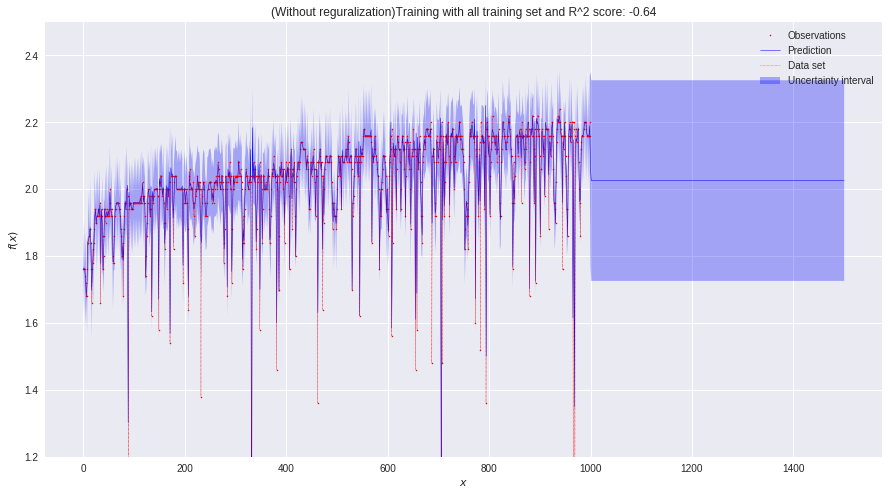

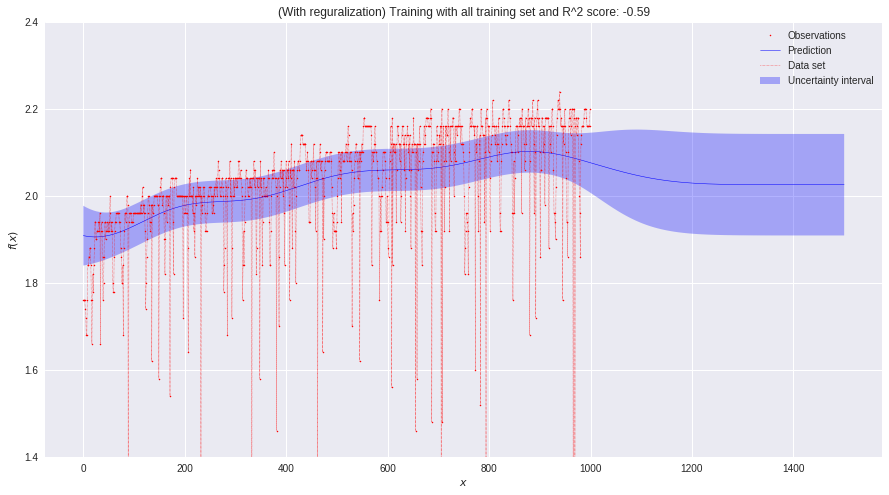

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import random
import seaborn as sns
import matplotlib.pyplot as plt


# Get the data-------------------------------
balloon_data = oml.datasets.get_dataset(512) 
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);
X_all = np.array(list(range(1500)))[np.newaxis].T
# Get the data---------------------------------

X_all = X_all.reshape((1500,1))
# X_last = X[:1500].reshape((1500,1))                                 
y = train[:1000]                               

y = np.reshape(y, (-1, 1))
X=X_train  


y = y.ravel()
# Mesh the input space for evaluations of the real function, the prediction and its MSE
x = np.atleast_2d(np.linspace(0, 1500, 1000)).T   #
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#we also have normalization to avoid the "drop" in the estimation area over 1000


#-----------Without reguralization----------------
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,normalize_y='true')  
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)    # y=raw data , X=1000 indices
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)
# Plot the function, the prediction and the 95% confidence interval based on the MSE
score = gp.score(X_all[1000:1500], test)     #we evaluate in the "test data" meaning the last 500 points

#print("Training set score (R^2): {:.2f}".format(gp.score(X_train, y_train[0:1000])))   <- to delete
fig = plt.figure(figsize=(15,8))
plt.plot(X, y, 'r.', markersize=3, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.plot(np.array(list(range(1000))), data[:1000], 'r:', label='Data set')   
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='b', ec='None', label='Uncertainty interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(1.2, 2.5)
plt.title("(Without reguralization)Training with all training set and R^2 score: {:.2f}" .format(score) )
plt.legend(loc='best');

#-----------With reguralization----------------
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,normalize_y='true',alpha=0.1)  
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)    # y=raw data , X=1000 indices
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)
# Plot the function, the prediction and the 95% confidence interval based on the MSE
score = gp.score(X_all[1000:1500], X_last[1000:1500])     #we evaluate in the "test set" meaning the last 500 points

#print("Training set score (R^2): {:.2f}".format(gp.score(X_train, y_train[0:1000])))   <- to delete
fig = plt.figure(figsize=(15,8))
plt.plot(X, y, 'r.', markersize=3, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.plot(np.array(list(range(1000))), data[:1000], 'r:', label='Data set')   
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='b', ec='None', label='Uncertainty interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(1.4, 2.4)
plt.title("(With reguralization) Training with all training set and R^2 score: {:.2f}" .format(score) )
plt.legend(loc='best');



**Team discussion**

The gp on top without regirulization clearly overfits the data, since the way we train it is like we do not expect any data from our data, which clearly is wrong.
As we know the baloon movement, is adding noise to our data so we try to plot the predictor with regurilizaion on the bottom. Clearly the prediction here
is better and smoother since here we expect a noise level in the observations.

In [16]:

# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);
data=X
train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1250)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T
y=np.reshape(y, (-1,1))
X_all = X_all.reshape((1500,1))
y = train[:1000]
y=np.reshape(y, (-1,1))
X_=X_train
y=y.ravel()
# Mesh the input space for evaluations of the real function, the prediction and its MSE
x = np.atleast_2d(np.linspace(0, 2000, 1000)).T


# Grid search

best_score = -100  # we use a very low threshold for the comparisons

for length_scale in [1, 5, 10, 20, 40]:
    for length_scale_bounds in [(1e-4,1e4),(1e-3,1e3),(1e-2,1e2),(1e-1,1e1)]:
        # for each combination of parameters
        # train a GP
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale, length_scale_bounds);
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y='true');
        gp.fit(X_,y)
        # evaluate the GP on the test set 
        score = gp.score(X_all[1000:1500], test)
        # if we got a better score, store the score and parameters
        score
        if score > best_score:
            best_score = score
            best_parameters = {'length_scale': length_scale, 'length_scale_bounds': length_scale_bounds}
            
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: -0.64
Best parameters: {'length_scale': 5, 'length_scale_bounds': (0.01, 100.0)}


**Team discussion**

By changing the parameters of the Kernell we can see that no difference can be observed in our R^2 scores from before.
The predictor as we can see in the top image from before(without regurilization) clearly overfits.
Instead we will try to find the best score for differrent alpha parameteres which reguralize.

In [18]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);
data=X
train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1250)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T
y=np.reshape(y, (-1,1))
X_all = X_all.reshape((1500,1))
y = train[:1000]

y=np.reshape(y, (-1,1))
X_=X_train
y=y.ravel()
# Mesh the input space for evaluations of the real function, the prediction and its MSE
x = np.atleast_2d(np.linspace(0, 2000, 1000)).T


# Grid search

best_score = -100  # we use a very low threshold for the comparisons

for a in [0.01,0.015,0.02,0.025,1e-10]:
      # for each combination of parameters
      # train a GP
      #kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale, length_scale_bounds);
      kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2));
      gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y='true',alpha=a);
      gp.fit(X_,y)
      # evaluate the GP on the test set 
      score = gp.score(X_all[1000:1500], test)
      # if we got a better score, store the score and parameters
      score
      if score > best_score:
          best_score = score
          best_parameters =  a
            
print("Best score: {:.2f}".format(best_score))
print("Best alpha: {}".format(best_parameters))

Best score: -0.54
Best alpha: 0.015


**Team discussion**

We see by changing the alpha parameter we get a slightly better score. The best parameter for alpha is also quite low which 
means that the noisy level in our observations is not that extreme. The preictos also does not get affected by extreme values as we can see in the bottom image
above (with regurilization) and seems to perform a lot smoother, which concludes that there is definitely some noise in our data.

## A data mining challenge (4 points)




The goal here is to use everything you have learned to build the best model for a given classification task. We will use two tasks hosted on OpenML, so you will all receive the same cross-validation splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection, pipeline building, and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial. You need to optimize the AUROC score (calculated using 10-fold cross0-validation).

- Challenge 1: Detects accents in speech data.

    - The OpenML Task ID is 167132: https://www.openml.org/t/167132
    - The dataset description can be found here: https://www.openml.org/d/40910
    - Leaderboard: https://www.openml.org/t/167132#!people
    
- Challenge 2: Image recognition (CIFAR-10 subsample).

    - The OpenML Task ID is 167133: https://www.openml.org/t/167133
    - The dataset description can be found here: https://www.openml.org/d/40926
    - Leaderboard: https://www.openml.org/t/167133#!people
    - Note that this is a high-dimensional dataset (and not so small). Think carefully about how to run experiments in the  time available.
    
- You are able to see the solutions of others (by clicking in the timeline or run list), so you can learn from prior experiments (what seems to work, how long does it take to train certain models, ...). Resubmission of the exact same solution is not possible.
- You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- Document the different experiments that you ran in this notebook (running them can of course be done outside of the notebook). For each experiment, provide a description of how and why you chose the algorithms and parameters that you submitted. Reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows (independently for each task):

    - 1 point for the breadth of experiments you ran (algorithms, pipelines, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Exception: simply repeating top models with nearly identical hyperparameters. This will be checked on the timeline.
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the leaderboard.
        
Note: Report the AUC scores of your best models in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

### Challenge 1

In [0]:
# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Linear regression algorithms
from sklearn.linear_model import LogisticRegression

# Linear classifier
from sklearn.neighbors import KNeighborsClassifier

# For the Scaler requested
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import MinMaxScaler

# To split data into test-train sets, cross-validation, grid search, randomized search
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, ShuffleSplit

# For pipelines
from sklearn.pipeline import make_pipeline

# For ensambles
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# For logging
import time

# For last question
from sklearn.metrics import roc_auc_score

# Scorers
from sklearn.metrics.scorer import SCORERS

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.manifold import TSNE

#### Getting OpenML information

The first thing to take into account for this Challenge is that we are using the OpenML API, this means that our classifiers are going to be run against a bunch of predifined parameters. In order to get these, we have used the `get_X_and_y` method to get the correspondant features and target, `get_train_test_split_indices` for the train and test indices and `split` to get the cross-validation folds that we need to pass to our evaluator. It comes interesting to mention that the cross-validation folds are returning indices for the original dataset dimensions - this is, the train-test indices are not used - and hence we need to use the original `X` and `y`. We decided to use these settings for our exploration to approximate to the results that can be obtained from the the OpenML Server.

Finally, we need to consider that the AUC scores computed by OpenML are given by the implementation described [here](https://www.openml.org/a/evaluation-measures/area-under-roc-curve), hence one would expect to see different scores for the sklearn implementation.

In [0]:
################################################################################
######################### To reproduce OpenML results  #########################
################################################################################
task = oml.tasks.get_task(167132)
# vars(task)

# Get dataset
X, y = task.get_X_and_y()

# Get train and test indicies
trainIndices, testIndices = task.get_train_test_split_indices()

# Build our train/test frames
X_train, y_train = X[trainIndices], y[trainIndices]
X_test, y_test = X[testIndices], y[testIndices]
split = task.split

# To build the 
cvOpenML = []
for i, aux in split.split[0].items():
    cvOpenML.append( (aux[0].train, aux[0].test) )

#### Experiments

**General methodology**

For Challenge 1 we have tried the next approach:

1. Run a set of candidate classifiers with their default parameters to see if one would perform better than the others.
2. Try different scalers for the same classifiers, again with the default values. Purpose is to see if any scaling makes a difference since the features are already lying in an small range.
3. Reason about the benefit of reducing dimensionality for this dataset and measure the effect on the algorithms
4. Out of the results we can observe, pick the most outstanding algorithms and try to tune their hyperparameters according to specific cases.

Our initial candidates are: KNeighborsClassifier, LogisticRegression, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GaussianNB, DecisionTreeClassifier and SVC.


**Scalers**

We notice that scaling the data is not making a huge difference on the results, moreover, Standard Scaler is the only one that gives a boost in the performance, but is not that significant. 

However, since the classifiers are not tunned we decide to run our experiments with this scaler as the default.

In [9]:
candidates = {
  "kneighborsclassifier" : KNeighborsClassifier(), 
  "logisticregression" : LogisticRegression(),
  "gradientboostingclassifier" : GradientBoostingClassifier(),
  "randomforestclassifier" : RandomForestClassifier(),
  "adaboostclassifier" : AdaBoostClassifier(),
  "gaussiannb" : GaussianNB(), 
  "decisiontreeclassifier" : DecisionTreeClassifier(),
  "svc" : SVC()
}

rsScalingResults = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(RobustScaler(), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1, n_jobs = 16)
  rsScalingResults.append([np.mean(cv_scores), np.var(cv_scores)])

mmScalingResults = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(MinMaxScaler(), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1, n_jobs = 16)
  mmScalingResults.append([np.mean(cv_scores), np.var(cv_scores)])


stdScalingResults = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(StandardScaler(), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1, n_jobs = 16)
  stdScalingResults.append([np.mean(cv_scores), np.var(cv_scores)])

noScalingResults = []
for name, algorithm in candidates.items():
  print("Running {} without scaling...".format(name))
  pipeline = make_pipeline(algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1, n_jobs = 16)
  noScalingResults.append([np.mean(cv_scores), np.var(cv_scores)])

Running kneighborsclassifier ...
Running logisticregression ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    7.2s finished


Running gradientboostingclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    4.1s finished


Running randomforestclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  2.0min finished


Running adaboostclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    6.6s finished


Running gaussiannb ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   59.8s finished


Running decisiontreeclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    0.9s finished


Running svc ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   39.0s finished


Running kneighborsclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    7.7s finished


Running logisticregression ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    7.5s finished


Running gradientboostingclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    2.3s finished


Running randomforestclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  2.0min finished


Running adaboostclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    6.2s finished


Running gaussiannb ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   59.2s finished


Running decisiontreeclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    0.6s finished


Running svc ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   38.6s finished


Running kneighborsclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    4.2s finished


Running logisticregression ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    7.6s finished


Running gradientboostingclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    3.9s finished


Running randomforestclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  2.0min finished


Running adaboostclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    6.2s finished


Running gaussiannb ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   59.3s finished


Running decisiontreeclassifier ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    0.6s finished


Running svc ...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   38.6s finished


Running kneighborsclassifier without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   10.4s finished


Running logisticregression without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    7.4s finished


Running gradientboostingclassifier without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    3.8s finished


Running randomforestclassifier without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  2.0min finished


Running adaboostclassifier without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    6.1s finished


Running gaussiannb without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   59.4s finished


Running decisiontreeclassifier without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    0.5s finished


Running svc without scaling...


[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   38.6s finished
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    8.9s finished


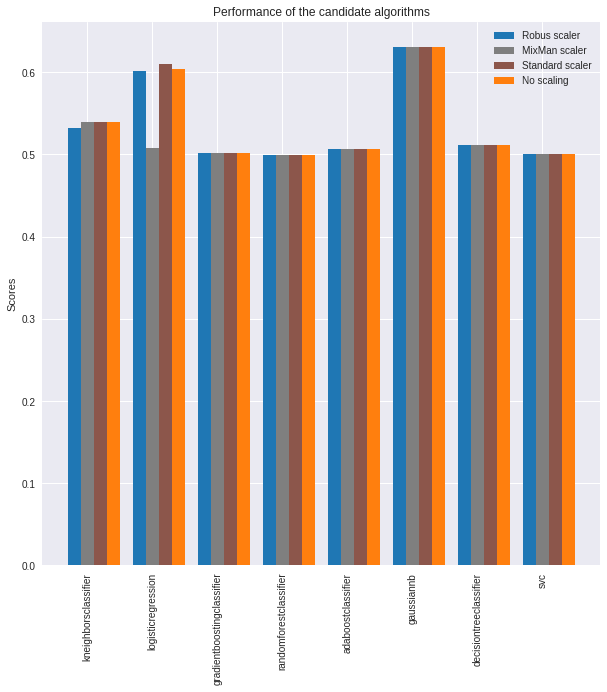

In [11]:
def plotComparison(A, B, C, D, labA, labB, labC, labD, candidates):
  ind = np.arange(len(candidates.keys()))
  width = 0.20      # the width of the bars

  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(111)

  rects1 = ax.bar(ind, pd.DataFrame(A)[0], width, color='tab:blue')
  rects2 = ax.bar(ind+width, pd.DataFrame(B)[0], width, color='tab:gray')
  rects3 = ax.bar(ind+width*2, pd.DataFrame(C)[0], width, color='tab:brown')
  rects4 = ax.bar(ind+width*3, pd.DataFrame(D)[0], width, color='tab:orange')

  ax.set_title("Performance of the candidate algorithms")
  ax.set_ylabel('Scores')
  ax.set_xticks(ind+width)
  ax.set_xticklabels( (candidates.keys()), rotation = 90 )
  ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), (labA, labB, labC, labD) )

  plt.show()

plotComparison(rsScalingResults, mmScalingResults, stdScalingResults, 
               noScalingResults, "Robust scaler", "MixMax scaler", 
               "Standard scaler", "No scaling", candidates)

**Dimensionality reduction**

For this step, we focused in the PCA approach only. We have first plotted a 2D version of the features to see if anything stands out from the picture, however no conclusions could be made from it. Then, we proceeded to measure the effect of different PCA reductions for each of the candidates. 

Our results showed that GaussianNB, SVC and Logistic Regression got no improvement with dimensionality reduction, Knn and AdaBoost seemed to work better with a reduction to 100 dimensions, RandomForest with 200 and GradientBoosting and DecisionTree with 300. We show the results in the cells below.


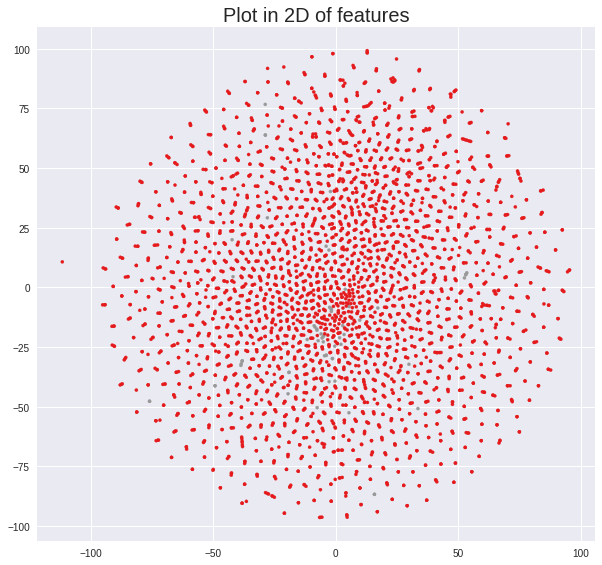

In [196]:

tsne = TSNE(n_components=2, verbose=1, random_state = 0)
transformation = tsne.fit_transform(X)

def plot_reduction(x, y, title):    
    # The get min and max of each axis to be able to plot with the correct dimensions.
    x0Max = max(x[:, 0])
    x1Max = max(x[:, 1])
    x0Min = min(x[:, 0])
    x1Min = min(x[:, 1])

    x1Size = x1Max - x1Min
    x0Size = x0Max - x0Min
    
    # Make the plot of the points 
    fig,ax = plt.subplots()
    fig.set_size_inches(10, (x1Size/x0Size)*10)
    plt.title(title, fontsize=20)
    plt.scatter(x[:,0], x[:,1], s = 10, c = y, cmap='Set1')
    
    plt.show()

# Plot a 2D representation of the dataset
plot_reduction(transformation, y, "Plot in 2D of features")

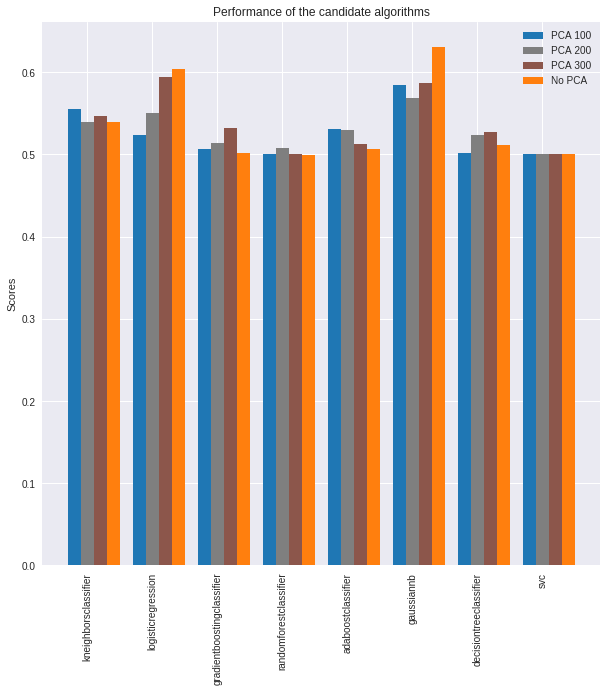

In [14]:
candidates = {
  "kneighborsclassifier" : KNeighborsClassifier(), 
  "logisticregression" : LogisticRegression(),
  "gradientboostingclassifier" : GradientBoostingClassifier(),
  "randomforestclassifier" : RandomForestClassifier(),
  "adaboostclassifier" : AdaBoostClassifier(),
  "gaussiannb" : GaussianNB(), 
  "decisiontreeclassifier" : DecisionTreeClassifier(),
  "svc" : SVC()
}

pca100Results = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(StandardScaler(), PCA(100), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1)
  pca100Results.append([np.mean(cv_scores), np.var(cv_scores)])

  
pca200Results = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(StandardScaler(), PCA(200), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1)
  pca200Results.append([np.mean(cv_scores), np.var(cv_scores)])


pca300Results = []
for name, algorithm in candidates.items():
  print("Running {} ...".format(name))
  pipeline = make_pipeline(StandardScaler(), PCA(300), algorithm)
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                            scoring = make_scorer(roc_auc_score), verbose = 1)
  pca300Results.append([np.mean(cv_scores), np.var(cv_scores)])

# Plot results
plotComparison(pca100Results, pca200Results, pca300Results, noScalingResults, 
               "PCA 100", "PCA 200", "PCA 300", "No PCA", candidates)

##### Knn

For this algorithm we tried to tune the number of neighbors first to an small number (2, 3 and 5) and tried different dimensionality reductions, included the ones we tested in our PCA experiment. We found that the best parameters were `n_neighbors = 3` and `n_components = 100`. We then compared the best parameters with a much bigger number of neighbors (100) and no better result could be found.

Our best score for this algorithm was measured as `0.8079` in the OpenML server: https://www.openml.org/r/8886374

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:  3.3min finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=100, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
{'kneighborsclassifier__n_neighbors': 3, 'pca__n_components': 100}
0.6700318014345624


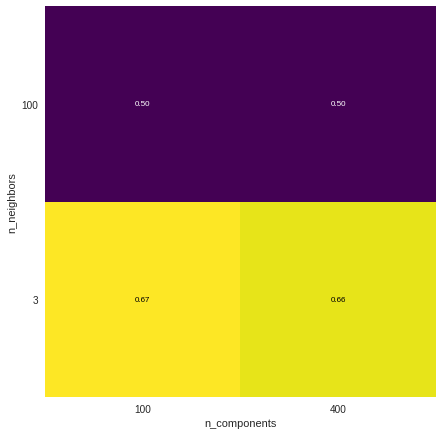

In [9]:
### Tunning knn
clf = KNeighborsClassifier()

params = {
#             "kneighborsclassifier__n_neighbors": [2, 3, 5],
#             "pca__n_components": [80, 100, 300, X.shape[1]]
            "kneighborsclassifier__n_neighbors": [3, 100],
            "pca__n_components": [100, X.shape[1]]

         }
pipeline = make_pipeline(StandardScaler(), PCA(random_state = 0), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)

fig, axis = plt.subplots(figsize = (7, 10))
scores = np.array(results.mean_test_score).reshape( len(params['kneighborsclassifier__n_neighbors']), len(params['pca__n_components']) )
mglearn.tools.heatmap(scores, ylabel='n_neighbors', yticklabels=params['kneighborsclassifier__n_neighbors'],
          xlabel='n_components', xticklabels=params['pca__n_components'], cmap="viridis", ax = axis);


In [18]:
### knn (final)
clf = KNeighborsClassifier(n_neighbors = 3)

  # Put yoir pipeline here
pipeline = make_pipeline(StandardScaler(), PCA(100), clf)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
# print(run.get_metric_fn(roc_auc_score))
# print(np.mean(run.get_metric_fn(roc_auc_score)))
myrun = run.publish()
print("\nUploaded {} to http://www.openml.org/r/{}".format(name, myrun.run_id))


Executing flow on task...

Uploaded svc to http://www.openml.org/r/8886374


##### GaussianNB

For this classifier we tried to tune the prior probabilities of the classes and we noticed that giving a pair or probabilites `(p1, p2)` the best result was obtained with probabilities `p1` close to 0 and `p2` close to 1. This intuitively makes sense since we know that the outliers in the dataset are a small proportion. Although different experiments have been made, we present the last comparison.

First, we tried to use the frequency per class in the dataset as prior probability, but we found that different values worked better. Indeed, the best result we could get was with probabilities `(0.06, 1 - 0.06)`. The best score we could obtain was 0.7726: https://www.openml.org/r/8886052

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    1.6s finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gaussiannb', GaussianNB(priors=[0.06, 0.94]))])
{'gaussiannb__priors': [0.06, 0.94]}
0.7129278229932817


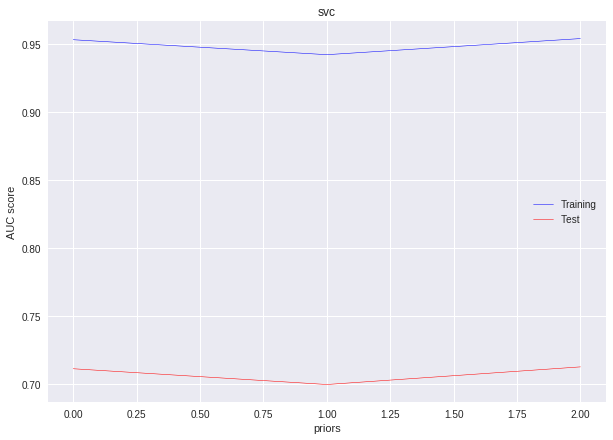

In [24]:
### Tunning GaussianNB
clf = GaussianNB()

params = {
            "gaussiannb__priors": [[0.055, 1 - 0.055],
                                   [0.016549104720564298, 1 - 0.016549104720564298],
                                   [0.06, 1 - 0.06]]
         }
pipeline = make_pipeline(StandardScaler(), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)

scoresTest = np.array(results.mean_test_score)
scoresTrain = np.array(results.mean_train_score)
fig, axis = plt.subplots(figsize = (10, 7))
plt.plot(range(len(params['gaussiannb__priors'])), scoresTrain, '-b', label = 'Training')
plt.plot(range(len(params['gaussiannb__priors'])), scoresTest, '-r', label = 'Test')
plt.xlabel('priors')
plt.ylabel('AUC score')
plt.title(name)
plt.legend()
plt.show()


In [25]:
### Tunning GaussianNB
clf = GaussianNB(priors = [0.06, 1 - 0.06])
pipeline = make_pipeline(StandardScaler(), clf)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
# print(run.get_metric_fn(roc_auc_score))
myrun = run.publish()
print("\nUploaded {} to http://www.openml.org/r/{}".format(name, myrun.run_id))


Executing flow on task...

Uploaded svc to http://www.openml.org/r/8886374


##### Logistic Regression

For this algorithm we tried to tune two hyperparameters: the `penalty` and `C`. We then observed that higher values of C tend fo overfit the data, as shown in the plot, we then focused in values that could avoid this problem (really low values). In the plot we just show the experiment that exposes this phenomena, and for the final submission we use one of the lower values we found. 

Our best algorithm performed with a score of 0.8577: https://www.openml.org/r/8886419


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:   16.6s finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
{'logisticregression__C': 10}
0.6239707480348695


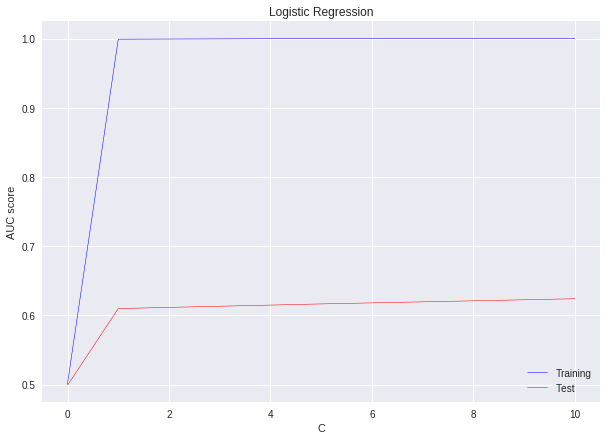

In [41]:
### Tunning LogisticRegression
clf = LogisticRegression()

params = {
#             "logisticregression__penalty": ["l1", "l2"],
#             "logisticregression__C": [10 ** -x for x in range(11, 22)]
            "logisticregression__C": [0.001, 0.01, 1, 5, 10 ]

         }
pipeline = make_pipeline(StandardScaler(), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)

scoresTest = np.array(results.mean_test_score)
scoresTrain = np.array(results.mean_train_score)
fig, axis = plt.subplots(figsize = (10, 7))
plt.plot(params['logisticregression__C'], scoresTrain, '-b', label = 'Training')
plt.plot(params['logisticregression__C'], scoresTest, '-r', label = 'Test')
plt.xlabel('C')
plt.ylabel('AUC score')
plt.title("Logistic Regression")
plt.legend()
plt.show()


In [40]:
clf = LogisticRegression(C = 0.00001)
pipeline = make_pipeline(StandardScaler(), clf)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
# print(run.get_metric_fn(roc_auc_score))
myrun = run.publish()
print("\nUploaded {} to http://www.openml.org/r/{}".format(name, myrun.run_id))


Executing flow on task...

Uploaded svc to http://www.openml.org/r/8886419


##### RandomForest

For this classifier we could not improve the results much more by tunning the hyperparameters. The selection of the `max_depth` values is supported by the results found in Assignment 1, then we have tested different estimators and the different max_features available, in joint with the PCA candidate found before. We had also tried different PCA combinations, but the results were poorer and are not included in the final submission.

In [0]:
### Tunning LogisticRegression
clf = RandomForestClassifier()

params = {
            "randomforestclassifier__max_features": [0.5, "sqrt", "log2"],,
            "randomforestclassifier__n_estimators": [3, 5, 7],
            "randomforestclassifier__max_depth": [ 2, 4, 8, 16, 32, 64]

         }
pipeline = make_pipeline(StandardScaler(), PCA(200), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.mean_test_score_)

results = pd.DataFrame(grid_search.cv_results_)

In [17]:
clf = RandomForestClassifier(max_depth = 64, max_features = "sqrt", n_estimators = 3)
pipeline = make_pipeline(StandardScaler(), PCA(200), clf)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
print(run.get_metric_fn(roc_auc_score))
myrun = run.publish()
print("\nUploaded to http://www.openml.org/r/{}".format(myrun.run_id))


Executing flow on task...
[0.5   0.5   0.499 0.496 0.5   0.5   0.5   0.499 0.579 0.499]

Uploaded to http://www.openml.org/r/8886866


##### SVC

For the SVM we tried to see the performance of the elemental kernels. We found that linear is giving the best results and hence we proceeded to optimize the parameters but no good results could be found. Our score reached a maximum of `0.6316` (https://www.openml.org/r/8886932).

It is important to mention that we additionally tried to reduce the dimensions with PCA to see if any improvements could be made but with these kernels it came hard to find a good solution.

In [23]:
# SVC 1
from sklearn.gaussian_process.kernels import Sum, Product
### Tunning SVC
clf = SVC()

params = {
            "svc__C": [0.01, 0.1, 1, 10],
            "svc__gamma": [0.01, 0.1, 1, 10],
            "svc__kernel": ["linear", "rbf", "poly"]
         }
pipeline = make_pipeline(StandardScaler(), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   47.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed: 12.1min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed: 34.8min
[Parallel(n_jobs=16)]: Done 480 out of 480 | elapsed: 40.7min finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
{'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
0.6294173493156341


In [29]:
# SVC 2
from sklearn.gaussian_process.kernels import Sum, Product
### Tunning SVC
clf = SVC(kernel = "linear")

params = {
            "svc__C": [0.03, 0.04, 0.05, 0.06],
            "svc__gamma": [0.001, 0.002, 0.003, 0.004]
         }
pipeline = make_pipeline(StandardScaler(), clf)

grid_search = GridSearchCV(pipeline, params, 
                           cv = cvOpenML, verbose = 1, n_jobs = 16, 
                           scoring = make_scorer(roc_auc_score))
grid_search.fit(X, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)
results = pd.DataFrame(grid_search.cv_results_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   20.9s
[Parallel(n_jobs=16)]: Done 160 out of 160 | elapsed:  1.8min finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.04, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
{'svc__C': 0.04, 'svc__gamma': 0.001}
0.6316002587379644


In [36]:
clf = SVC(gamma = 0.001, C = 0.04, kernel = 'linear')
pipeline = make_pipeline(StandardScaler(), clf)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
print(run.get_metric_fn(roc_auc_score))
myrun = run.publish()
print("\nUploaded to http://www.openml.org/r/{}".format(myrun.run_id))


Executing flow on task...
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

Uploaded to http://www.openml.org/r/8886941


#### Final discussion

We found that the problem was hard to tackle due to the high dimensionality and the unbalanced nature of the dataset, which leads to a poor score in the AUC metric. Our best result was found with LogisticRegression classifier and Knn, with scores above 80%. 

We consider that the 2D plot we presented in the experiments suggests that a good SVM kernel could lead to good results by grouping elements in the center of the representation, but we could not solve this problem.

### Challenge 2

In [0]:
from sklearn import pipeline, ensemble, preprocessing, feature_selection, svm
from openml import tasks, runs, datasets
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [0]:
oml.config.apikey ='4445c4569b060a3e6bb3cc57d235aa3a'



For Challenge 2 we have followed the same patern of challenge 1 but due to the size of the data set did not try all posssible classifiers. 
3 classifiers were used in the end: 1:RandomForestClassifier, 2:Adam Booster, 3:Adam Booster
Moreover due the large number of feautures we used pca, for dimensionality reduction. We compared the results for the classifiers ith and without PCA, and with the right parameter PCA managed to provide better results. 
        
The choice of the classifiers was made mainly based on time constraints. Random Forest was a logical first choice since we have multiple classes for classification, and is fast.
We also tried SVM and gradient boosting but the computational time was too large.
Adam Booster was also used since it is, like Random Forest Classifier, another ensemble classifier.Adaboost like random forest classifier gives more accurate results 
since it depends upon many weak classifier for final decision. One of the applications to Adaboost is for face recognition systems and images so it seemed appropriate for this case. Finally we used kNN
(after PCA)
We tried different hyperparameters for each classifier and then focused to the range that provided the best scores.

In [0]:
#-----------GET TASK AND DATA--------
task = oml.tasks.get_task(167133)
vars(task)

# XEROX

# Get dataset
X, y = task.get_X_and_y()

# Get train and test indicies
trainIndices, testIndices = task.get_train_test_split_indices()

# Build our train/test frames
X_train, y_train = X[trainIndices], y[trainIndices]
X_test, y_test = X[testIndices], y[testIndices]

# To build the 
split = task.split
cvOpenML = []
for i, aux in split.split[0].items():
    cvOpenML.append( (aux[0].train, aux[0].test) )

In [42]:
X_train.shape
y.shape

(20000,)

In [28]:
#Without PCA
est = [15,20,25]
results_rf=[]
for estimators in est:
  candidates = {
    "randomforestclassifier" : RandomForestClassifier(estimators),
  }
  for name, algorithm in candidates.items():
    print("Running {} ...".format(name))
    pipeline = make_pipeline(StandardScaler(), algorithm) 
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                              scoring = make_scorer(accuracy_score), verbose = 1)
  results_rf.append([np.mean(cv_scores)])

Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.3min finished


In [14]:
results_rf

[[0.3538], [0.3781], [0.38239999999999996]]

In [15]:
#With PCA
est = [15,20,25]
results_rf_pca=[]
for estimators in est:
  candidates = {
    "randomforestclassifier" : RandomForestClassifier(estimators),
  }
  for name, algorithm in candidates.items():
    print("Running {} ...".format(name))
    pipeline = make_pipeline(StandardScaler(), PCA(25), algorithm) 
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                              scoring = make_scorer(accuracy_score), verbose = 1)
  results_rf_pca.append([np.mean(cv_scores)])
  
  

Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [16]:
results_rf_pca

[[0.36455], [0.38310000000000005], [0.3942]]

As we can see PCA combined with Random firest gave an accuracy score of 39.5% while wihout PCA 38.2%. Below we run Random forest again with PCA for a higher number of estimators.

In [44]:
#Since we have seen that PCA provides better results we know run our classifier with the "correct" parameters.
est = [80,100,120]
results_rf_pca=[]
for estimators in est:
  candidates = {
    "randomforestclassifier" : RandomForestClassifier(estimators),
  }
  for name, algorithm in candidates.items():
    print("Running {} ...".format(name))
    pipeline = make_pipeline(StandardScaler(), PCA(25), algorithm) 
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                              scoring = make_scorer(accuracy_score), verbose = 1)
  results_rf_pca.append([np.mean(cv_scores)])
  

Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.5min finished


Running randomforestclassifier ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished


In [45]:
results_rf_pca

[[0.4373], [0.43955], [0.44300000000000006]]

Best Score for Random Forest : 44.3%
Best parameters for Random Forest : number of estimators = 120


In [17]:
results_knn=[]
for k in [3,5,7]:
  candidates = {
    "KNN" : KNeighborsClassifier(k),
  }
  for name, algorithm in candidates.items():
    print("Running {} ...".format(name))
    pipeline = make_pipeline(StandardScaler(), PCA(25), algorithm) 
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                              scoring = make_scorer(accuracy_score), verbose = 1)
  results_knn.append([np.mean(cv_scores)])

Running KNN ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.2s finished


Running KNN ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.0s finished


Running KNN ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.3s finished


In [18]:
results_knn

[[0.3420500000000001], [0.36819999999999997], [0.378]]

Best Score for  kNN : 37.8%
Best parameters for kNN: number of NEIGHBOURS = 7

In [37]:
results_adam=[]
est = [30,35,40]
rate = [0.5,0.7,1]
for estimators,my_rate in zip(est, rate):
  candidates = {
    "Adam:" : AdaBoostClassifier(n_estimators=estimators, learning_rate=my_rate)
  }
  for name, algorithm in candidates.items():
    print("Running {} ...".format(name))
    pipeline = make_pipeline(StandardScaler(), PCA(25), algorithm) 
  cv_scores = cross_val_score(pipeline, X, y, cv = cvOpenML, 
                              scoring = make_scorer(accuracy_score), verbose = 1)
  results_adam.append([np.mean(cv_scores)])
  #0.3338

Running Adam: ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


Running Adam: ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


Running Adam: ...


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


In [39]:
results_adam

[[0.3266], [0.333], [0.32675000000000004]]

Best Score for  Adam Booster : 33.3%
Best parameters for Adam booster: number of estimators= 35
                         learning rate =0.7
    


Here we include a summary of the classifier with theire corresponding best scores:
Best Score for Random Forest : 44.3%
Best parameters for Random Forest : number of estimators = 120

    
Best Score for  kNN : 37.8%
Best parameters for kNN: number of NEIGHBOURS = 7

Best Score for  Adam Booster : 33.3%
Best parameters for Adam booster: number of estimators= results_adam
                         learning rate =0.7

As we can see the best classifier for this data set was Random Forest with 120 estimators.

In [46]:
#----Upload the best classifier with best parameters------
alg=RandomForestClassifier(n_estimators=120)
pipeline = make_pipeline(StandardScaler(),PCA(25), alg)
flow = oml.flows.sklearn_to_flow(pipeline)
print("Executing flow on task...")
run = oml.runs.run_flow_on_task(task, flow)
modelRun = run.model
print(run.get_metric_fn(accuracy_score))
myrun = run.publish()
print("\nUploaded {} to http://www.openml.org/r/{}".format(name, myrun.run_id))


Executing flow on task...
[0.433 0.443 0.447 0.447 0.439 0.446 0.435 0.468 0.45  0.449]

Uploaded randomforestclassifier to http://www.openml.org/r/8886943
